In [405]:
# plot validation results given dictionary of samples produced using Validation-LEAF-Toolbox.ipynb
#the dictionary keys correspond to GEE feature collections for the original site in-situ data and the
# values corresponds to a list of in-situ samples with available product retrievals

In [312]:
conda install seaborn
conda install -c conda-forge scikit-learn


SyntaxError: invalid syntax (3055147781.py, line 1)

In [313]:
conda install scipy

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.14.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/richard_fernandes/anaconda3/envs/validation

  added / updated specs:
    - scipy


The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2022.6.1~ --> pkgs/main::ca-certificates-2022.07.19-h06a4308_0

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            conda-forge/noarch::certifi-2022.6.15~ --> pkgs/main/linux-64::certifi-2022.6.15-py39h06a4308_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [314]:
# import packages
import folium
import time
from folium import plugins
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
import math 
from sklearn.linear_model import TheilSenRegressor
from numpy import nan
import scipy

In [1337]:
# parameters
sampleLAIFileName = "/home/richard_fernandes/validation/LAI7dDictionary40mv2.pkl"
samplefCOVERFileName = "/home/richard_fernandes/validation/fCOVER7dDictionary40mv2.pkl"
samplefAPARFileName = "/home/richard_fernandes/validation/fAPAR7dDictionary40mv2.pkl"

siteFileName = "/home/richard_fernandes/validation/siteSummaries.csv"
variableName = "LAI"
sites_North_America = ['Barrow','BartlettExperimentalForest','BlandyExperimentalFarm','Bondville','Boulder','CentralPlainsExperimentalRange','DeadLake','DesertRock','DesMoines','DisneyWildernessPreserve','DukeForest', \
                        'FortPeck','GoodwinCreek','GuanicaForest','HarvardForest','ImnavaitCreek','JonesEcologicalResearchCenter','KonazPrairieBiologicalStation','LajasExperimentalStation','Manhattan', \
                       'NiwotRidgeForest','NiwotRidgeMountainResearchStation','NorthSterling','OakRidge','OnaquiAult','OrdwaySwisherBiologicalStation','RockSprings','SantaBarbara','SantaRita','SiouxFallsSurfRad',\
                       'SiousFallsUscrn','SmithsonianConservationBiologyInstitute','SmithsonianEnvironmentalResearchCenter','SouthernGreatPlains','StiegerwaldtLandServices','TableMountan',\
                       'TalladegaNationalForest','TonziRanch','Underc','WalnutGulchKendall','Williams','Woodworth','YosemiteVillage', \
                        'Geraldton2020', 'HayRiver2019' ,'Labrador2019' ,'Merbleue2019','MtPolley2019','PeaceRiver2019' ,'TurkeyPoint2019' ,'VancouverIsland2019','YellowKnife2019', 'NovaScotia2021']
treed_IGBP_class = ['Evergreen Broadleaf', 'Evergreen Needleleaf', 'Mixed Forest','Deciduous Broadleaf','Closed Shrublands','Open Shrublands']

sites_North_AmericaALL = ['Barrow','BartlettExperimentalForest','BlandyExperimentalFarm','Bondville','Boulder','CentralPlainsExperimentalRange','DeadLake','DesertRock','DesMoines','DisneyWildernessPreserve','DukeForest', \
                        'FortPeck','GoodwinCreek','GuanicaForest','HarvardForest','ImnavaitCreek','JonesEcologicalResearchCenter','Jornada','KonazPrairieBiologicalStation','LajasExperimentalStation','Manhattan','Moab', \
                       'NiwotRidgeForest','NiwotRidgeMountainResearchStation','NorthSterling','OakRidge','OnaquiAult','OrdwaySwisherBiologicalStation','RockSprings','SantaBarbara','SantaRita','SiouxFallsSurfRad',\
                       'SiousFallsUscrn','SmithsonianConservationBiologyInstitute','SmithsonianEnvironmentalResearchCenter','SouthernGreatPlains','StiegerwaldtLandServices','TableMountan',\
                       'TalladegaNationalForest','TonziRanch','Underc','WalnutGulchKendall','Williams','Woodworth','YosemiteVillage', \
                        'Geraldton2020', 'HayRiver2019' ,'Labrador2019' ,'Merbleue2019','MtPolley2019','PeaceRiver2019' ,'TurkeyPoint2019' ,'VancouverIsland2019','YellowKnife2019', 'NovaScotia2021']


In [1155]:
# compute residuals
def summaryStats(samplesDF,samplesLAIDF,xvariable,yvariable,trimquantile,minPAI):
    estimateMedian = [] 
    estimateSTD = [] 
    medianError = [] 
    estimateCount = [] 
    samplesDF = samplesDF.join(samplesLAIDF[samplesLAIDF.columns.difference(samplesDF.columns)])
    samplesDF = pd.concat([samplesDF.loc[samplesDF['network']=='CCRS'],samplesDF.loc[(samplesDF['PAI_total']>minPAI) & (samplesDF['network']=='GBOV')]],axis=0)
    for index, sample in samplesDF.iterrows():
        reference = sample[yvariable]
        qc = sample['sample'+xvariable][1]['data']
        estimate = sample['sample'+xvariable][2]['data']
        error = sample['sample'+xvariable][5]['data']
        productDF = pd.DataFrame(list(zip(qc,estimate,error)),columns=['qc','estimate','error'])
        productDF = productDF.loc[productDF['qc']==0]
        if productDF.shape[0]>0 :
            productDF['absresidual'] = (productDF['estimate'] - reference).abs()
            quantileResidual = productDF['absresidual'].quantile(trimquantile/100,interpolation='nearest')
            estimateMedian.append(productDF.loc[productDF['absresidual']==quantileResidual]['estimate'].median())
            estimateSTD.append(productDF.loc[productDF['absresidual']<=quantileResidual,['estimate']].std().divide((productDF.loc[productDF['absresidual']<=quantileResidual].shape[0]) ** (0.5)))
            medianError.append(productDF.loc[productDF['absresidual']==quantileResidual]['error'].median())
            estimateCount.append(productDF.loc[productDF['absresidual']<=quantileResidual].shape[0])
        else:
            estimateMedian.append(nan)
            estimateSTD.append(nan)
            medianError.append(nan)
            estimateCount.append(0)
    samplesDF[xvariable+'_'+yvariable+'_estimate'] = estimateMedian
    samplesDF[xvariable+'_'+yvariable+'_estimate_std'] = estimateSTD 
    samplesDF[xvariable+'_'+yvariable+'_err_estimate_mean'] = medianError
    samplesDF[xvariable+'_'+yvariable+'_estimate_count'] = estimateCount
    return(samplesDF)
   

In [1156]:
# renames columns of in-situ validation samples to standard names
def renameColumns(siteDF) :
    if 'GBOV' in siteDF.name:   
        siteDF['network'] = 'GBOV'
        newNames = {'Site': 'Site', \
                        'FCOVER_down': 'fCOVER_down', \
                        'FCOVER_up': 'fCOVER_up', \
                        'FCOVER_down_err': 'fCOVER_down_err', \
                        'FCOVER_up_err': 'fCOVER_up_err', \
                        'FIPAR_down': 'fAPAR_down', \
                        'FIPAR_up': 'fAPAR_up', \
                        'FIPAR_down_err': 'fAPAR_down_err', \
                        'FIPAR_up_err': 'fAPAR_up_err', \
                        'LAI_Warren_up': 'PAI_up', \
                        'LAI_Warren_down': 'PAI_down', \
                        'LAIe_Warren_up': 'PAIe_up', \
                        'LAIe_Warren_down': 'PAIe_down', \
                        'LAIe_Miller_up': 'PAIe_Miller_up', \
                        'LAIe_Miller_down': 'PAIe_Miller_down', \
                        'LAI_Warren_up_err': 'PAI_up_err', \
                        'LAI_Warren_down_err': 'PAI_down_err', \
                        'LAIe_Warren_up_err': 'PAIe_up_err', \
                        'LAIe_Warren_down_err': 'PAIe_down_err', \
                        'LAIe_Miller_up_err': 'PAIe_Miller_up_err', \
                        'LAIe_Miller_down_err': 'PAIe_Miller_down_err'} 
    elif 'CCRS' in siteDF.name:
        list(siteDF)
        siteDF['network'] = 'CCRS'
        siteDF['IGBP_class'] = 'Mixed Forest'
        siteDF.loc[siteDF['BF']>0.75,'IGBP_class'] = 'Deciduous Broadleaf'
        siteDF.loc[siteDF['BF']<0.25,'IGBP_class'] = 'Evergreen Needleleaf'
        newNames = {'Location': 'Site', \
                    'BF' : 'fBroadleaf' , \
                    'NF': 'fNeedleafleaf' , \
                    'fcover_Down': 'fCOVER_down', \
                    'fcover_Up': 'fCOVER_up', \
                    'fcoverstd_Down': 'fCOVER_down_err', \
                    'fcoverstd_Up': 'fCOVER_up_err', \
                    'Daily_Integrated_Black_Sk_yfAPAR_Down': 'fAPAR_down', \
                    'Daily_Integrated_Black_Sk_yfAPAR_Up': 'fAPAR_up' , \
                    'Daily_Integrated_Black_Sky_fAPAR_Down': 'fAPAR_down', \
                    'Daily_Integrated_Black_Sky_fAPAR_Up': 'fAPAR_up' , \
                    'PAICEV61_Up': 'PAI_up', \
                    'PAICEV61_Down': 'PAI_down', \
                    'PAIeCEV61_Up': 'PAIe_up', \
                    'PAIeCEV61_Down':'PAIe_down', \
                    'PAIEMiller_Up': 'PAIe_Miller_up', \
                    'PAIEMiller_Down':'PAIe_Miller_down', \
                    'Woody_Fraction_average':'WAItoPAIratio', \
                    'Woody_Fraction_std': 'WAItoPAIratio_err' }  
    
    return  siteDF.rename(columns = newNames)


In [1284]:
def estimateWAItoPAIratio2(samplesDF) :
    
    #default value for understory
    samplesDF['WAItoPAIratio_down'] = 0.1

    #estimate overstory woody to total area ratio for GBOV sites
    # use initial fixed ratio for all sites based on shrubs
    samplesDF.loc['WAItoPAIratio'] = 0.10
    samplesDF.loc['WAItoPAIratio_std'] = 0.11
    
    # use fixed ratio for needeleaf sites
    samplesDF.loc[(samplesDF['IGBP_class'] == 'Evergreen Needleleaf'),'WAItoPAIratio'] = 0.16
    samplesDF.loc[(samplesDF['IGBP_class'] == 'Evergreen Needleleaf'),'WAItoPAIratio_std'] = 0.10   
    samplesDF.loc[(samplesDF['IGBP_class'] == 'Deciduous Needleleaf'),'WAItoPAIratio'] = 0.16
    samplesDF.loc[(samplesDF['IGBP_class'] == 'Deciduous Needleleaf'),'WAItoPAIratio_std'] = 0.10  

    # use fixed ratio for  broadleaf sites
    samplesDF.loc[(samplesDF['IGBP_class'] == 'Evergreen Broadleaf'),'WAItoPAIratio'] = 0.24
    samplesDF.loc[(samplesDF['IGBP_class'] == 'Evergreen Broadleaf'),'WAItoPAIratio_std'] = 0.11
    samplesDF.loc[(samplesDF['IGBP_class'] == 'Deciduous Broadleaf'),'WAItoPAIratio'] = 0.24
    samplesDF.loc[(samplesDF['IGBP_class'] == 'Deciduous Broadleaf'),'WAItoPAIratio_std'] = 0.11


    # use fixed ratio for mixed forest
    samplesDF.loc[(samplesDF['IGBP_class'] == 'Mixed Forest'),'WAItoPAIratio'] = 0.18
    samplesDF.loc[(samplesDF['IGBP_class'] == 'Mixed Forest'),'WAItoPAIratio_std'] = 0.11

    # use fixed ratio for closed shrublands
    samplesDF.loc[samplesDF['IGBP_class'] == 'Open Shrublands','WAItoPAIratio_down'] = 0
    samplesDF.loc[samplesDF['IGBP_class'] == 'Open Shrublands','WAItoPAIratio'] = 0
    samplesDF.loc[samplesDF['IGBP_class'] == 'Open Shrublands','WAItoPAIratio_std'] = 0
    
    # use fixed ratio for mixed forest
    samplesDF.loc[samplesDF['IGBP_class'] == 'Open Shrublands','WAItoPAIratio_down'] = 0
    samplesDF.loc[samplesDF['IGBP_class'] == 'Open Shrublands','WAItoPAIratio'] = 0
    samplesDF.loc[samplesDF['IGBP_class'] == 'Open Shrublands','WAItoPAIratio_std'] = 0

    # fix some transcription errors in WAI to PAI ratio for CCRS
    samplesDF['WAItoPAIratio'] = samplesDF['WAItoPAIratio'].clip(lower=0.1,upper=0.24)
    samplesDF['WAItoPAIratio_std'] = samplesDF['WAItoPAIratio_std'].clip(lower=0.1,upper=0.11)
    return (samplesDF)


In [1285]:
def estimateWAItoPAIratio(samplesDF) :
    
    #default value for understory
    samplesDF['WAItoPAIratio_down'] = 0.1
    samplesDF.loc['WAItoPAIratio_std'] = 0.11

    #estimate overstory woody to total area ratio for GBOV sites
    # use initial fixed ratio for all sites based on shrubs
    samplesDF.loc[(samplesDF['network'] == 'GBOV') ,'WAItoPAIratio'] = 0.10
    samplesDF.loc[(samplesDF['network'] == 'GBOV') ,'WAItoPAIratio_std'] = 0.11

    # use fixed ratio for needeleaf sites
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Evergreen Needleleaf'),'WAItoPAIratio'] = 0.16
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Evergreen Needleleaf'),'WAItoPAIratio_std'] = 0.10   
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Deciduous Needleleaf'),'WAItoPAIratio'] = 0.16
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Deciduous Needleleaf'),'WAItoPAIratio_std'] = 0.10  

    # use fixed ratio for  broadleaf sites
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Evergreen Broadleaf'),'WAItoPAIratio'] = 0.24
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Evergreen Broadleaf'),'WAItoPAIratio_std'] = 0.11
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Deciduous Broadleaf'),'WAItoPAIratio'] = 0.24
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Deciduous Broadleaf'),'WAItoPAIratio_std'] = 0.11


    # use fixed ratio for mixed forest
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Mixed Forest'),'WAItoPAIratio'] = 0.18
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Mixed Forest'),'WAItoPAIratio_std'] = 0.11

    # use fixed ratio for closed shrublands
    samplesDF.loc[samplesDF['IGBP_class'] == 'Open Shrublands','WAItoPAIratio_down'] = 0
    samplesDF.loc[samplesDF['IGBP_class'] == 'Open Shrublands','WAItoPAIratio'] = 0
    samplesDF.loc[samplesDF['IGBP_class'] == 'Open Shrublands','WAItoPAIratio_std'] = 0
    
    # use fixed ratio for mixed forest
    samplesDF.loc[samplesDF['IGBP_class'] == 'Open Shrublands','WAItoPAIratio_down'] = 0
    samplesDF.loc[samplesDF['IGBP_class'] == 'Open Shrublands','WAItoPAIratio'] = 0
    samplesDF.loc[samplesDF['IGBP_class'] == 'Open Shrublands','WAItoPAIratio_std'] = 0

    # fix some transcription errors in WAI to PAI ratio for CCRS
    samplesDF['WAItoPAIratio'] = samplesDF['WAItoPAIratio'].clip(lower=0.1,upper=0.24)
    samplesDF['WAItoPAIratio_std'] = samplesDF['WAItoPAIratio_std'].clip(lower=0.1,upper=0.11)
    return (samplesDF)

[0.04902222] 0.0017356828964832463
[0.04500486] 0.012246451256410287
[-0.08899538] 0.050037813933810425


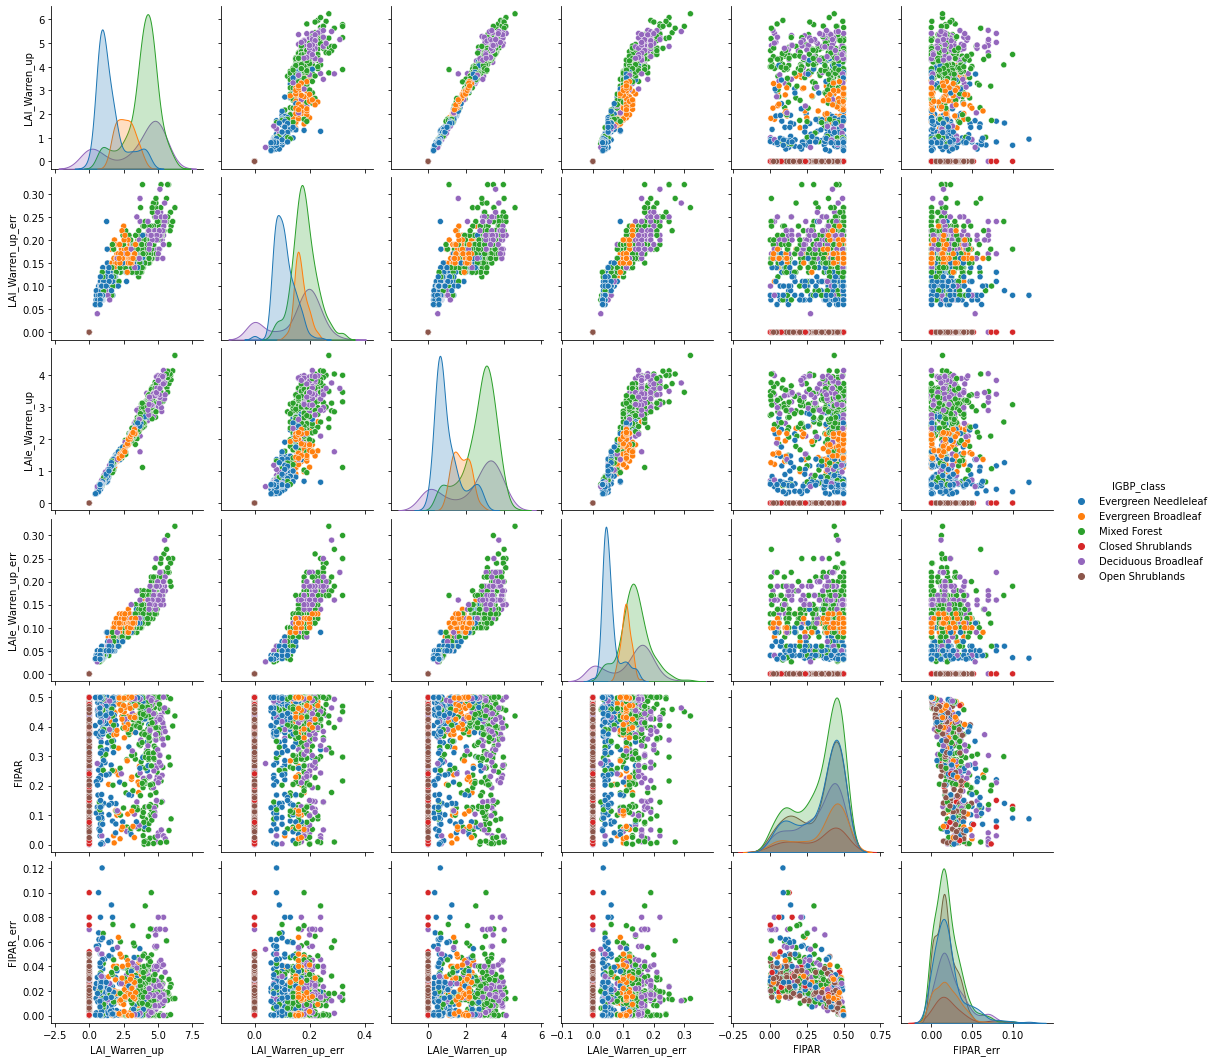

In [1286]:
#calibrating models to estimate insitu error for LAI and LAIe as a function of LAI or LAIe for GBOV
#this is to gap fill missing estimates og insitu error for CCRS plots
with open(samplefCOVERFileName, "rb") as fp:   #Pickling
    sampleDictionary = pickle.load(fp)
samplesfCOVERDF = pd.DataFrame(sampleDictionary['projects/ccmeo-ag-000008/assets/validationGBOV/COPERNICUS_GBOV_RM4_20220616174529']).reset_index(drop=True)
with open(sampleLAIFileName, "rb") as fp:   #Pickling
    sampleDictionary = pickle.load(fp)
samplesLAIDF = pd.DataFrame(sampleDictionary['projects/ccmeo-ag-000008/assets/validationGBOV/COPERNICUS_GBOV_RM7_20220616174529']).reset_index(drop=True)
with open(samplefAPARFileName, "rb") as fp:   #Pickling
    sampleDictionary = pickle.load(fp)
samplesfAPARDF = pd.DataFrame(sampleDictionary['projects/ccmeo-ag-000008/assets/validationGBOV/COPERNICUS_GBOV_RM6_20220616174529']).reset_index(drop=True)
samplesDF = samplesLAIDF.join(samplesfCOVERDF[samplesfCOVERDF.columns.difference(samplesLAIDF.columns)])
samplesDF = samplesDF.join(samplesfAPARDF[samplesfAPARDF.columns.difference(samplesDF.columns)])
samplesDF = samplesDF[samplesDF['IGBP_class'].isin(treed_IGBP_class)]
samplesDF = samplesDF[samplesDF['Site'].isin(sites_North_America)].reset_index()
samplesDF = samplesDF.drop(samplesDF[samplesDF['Elevation'] > 3000].index)
samplesDF[['LAI_Warren_up','LAI_Warren_up_err','LAIe_Warren_up','LAIe_Warren_up_err','FIPAR_down_err','FIPAR_down','FIPAR_up_err','FIPAR_up']] = samplesDF[['LAI_Warren_up','LAI_Warren_up_err','LAIe_Warren_up','LAIe_Warren_up_err','FIPAR_down_err','FIPAR_down','FIPAR_up_err','FIPAR_up']].apply(pd.to_numeric)
samplesDF = samplesDF.replace(-999, 0)
samplesDF = samplesDF[samplesDF['FIPAR_down']<1].reset_index()
samplesDF['FIPAR'] = samplesDF['FIPAR_up'].add((samplesDF['FIPAR_up']).mul(-1).add(1).mul(samplesDF['FIPAR_down'])).add(-0.5).abs()
samplesDF['FIPAR_err'] = samplesDF['FIPAR_up_err'].add((samplesDF['FIPAR_up']).mul(-1).add(1).mul(samplesDF['FIPAR_down_err']))

samplesDFfig1 = samplesDF[['LAI_Warren_up','LAI_Warren_up_err','LAIe_Warren_up','LAIe_Warren_up_err','FIPAR','FIPAR_err','IGBP_class']]
g = sns.pairplot(samplesDFfig1,hue='IGBP_class')
regLAIeerrvsLAIe = TheilSenRegressor(random_state=0).fit(samplesDF[['LAIe_Warren_up']].values.ravel().reshape(-1, 1), samplesDF[['LAIe_Warren_up_err']].values.ravel())

regLAIerrvsLAI = TheilSenRegressor(random_state=0).fit(samplesDF[['LAI_Warren_up']].values.ravel().reshape(-1, 1), samplesDF[['LAI_Warren_up_err']].values.ravel())
regfAPARerrvsfAPAR = TheilSenRegressor(random_state=0).fit(samplesDF[['FIPAR']].values.ravel().reshape(-1, 1), samplesDF[['FIPAR_err']].values.ravel())
print(regLAIeerrvsLAIe.coef_,regLAIeerrvsLAIe.intercept_)
print(regLAIerrvsLAI.coef_,regLAIerrvsLAI.intercept_)
print(regfAPARerrvsfAPAR.coef_,regfAPARerrvsfAPAR.intercept_)



In [1340]:
def parseSampleFile(sampleFileName,variableName):
    #laie err vs laie[0.04830027] 0.002163865830433743
 #lai err vs LAI [0.04480655] 0.010224858872736227
#fapar error vs  fAPAR[0.00798831] 0.0032205732237935323
    # clumping uncertainty
    clumping_err = 0.025

    
    with open(sampleFileName, "rb") as fp:   #Pickling
        sampleDictionary = pickle.load(fp)
    sitesList = sampleDictionary.keys()
    samplesDF = pd.DataFrame();
    
    for key in sitesList:

        #convert list to pandas data frame, rename columns, filter for North America
        siteDF = pd.concat([pd.DataFrame(sampleDictionary[key]),pd.DataFrame([key] * len(sampleDictionary[key]),columns=['geeFeatureCollection'])],axis=1)
        siteDF.name = key
        siteDF = renameColumns(siteDF)
        


        siteDF = siteDF[siteDF['IGBP_class'].isin(treed_IGBP_class)]
        siteDF = siteDF[siteDF['Site'].isin(sites_North_America)].reset_index()
        #number of samples and number valid samples
        numValid = []
        numSamples = []
        for index,site in siteDF.iterrows():
            siteQC = site['sample'+variableName][1]['data']
            numSamples.append(len(siteQC))
            numValid.append(len(siteQC) - np.count_nonzero(siteQC))
        numSamplesDF= pd.DataFrame(numSamples,columns=['numSamples'])
        numValidDF = pd.DataFrame(numValid,columns=['numValid'])
        siteDF = pd.concat([siteDF,numSamplesDF, numValidDF],axis=1)
        samplesDF = pd.concat([samplesDF,siteDF],axis=0,ignore_index=True)
    
    samplesDF = samplesDF.reset_index(drop=True)
    if variableName == 'LAI' :
        
        
        samplesDF[['PAI_up','PAI_down','PAIe_up','PAIe_down','PAI_up_err','PAI_down_err','PAIe_up_err','PAIe_down_err']] = samplesDF[['PAI_up','PAI_down','PAIe_up','PAIe_down','PAI_up_err','PAI_down_err','PAIe_up_err','PAIe_down_err']].apply(pd.to_numeric)
        samplesDF = samplesDF.replace(-999, 0)

        # gap fill estimates of insitu error for CCRS
        samplesDF.loc[samplesDF['network'] == 'CCRS','PAIe_up_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','PAIe_up'].mul(0.04830027).add(0.002163865830433743)
        samplesDF.loc[samplesDF['network'] == 'CCRS','PAIe_down_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','PAIe_down'].mul(0.04830027).add(0.002163865830433743)        
        samplesDF.loc[samplesDF['network'] == 'CCRS','PAI_up_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','PAI_up'].mul(0.04480655).add(0.010224858872736227)
        samplesDF.loc[samplesDF['network'] == 'CCRS','PAI_down_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','PAI_down'].mul(0.04480655).add(0.010224858872736227)

        
        samplesDF['percentValid'] = samplesDF['numValid'].div(samplesDF['numSamples'])
        
        # add error due to uncertainty in clumping
        samplesDF['PAI_up_err_clumping'] = samplesDF['PAI_up'].mul(samplesDF['PAI_up'].div((samplesDF['PAIe_up']).add(0.0001)).mul(clumping_err))
        samplesDF['PAI_up_err'] = samplesDF['PAI_up_err'].pow(2).add(samplesDF['PAI_up_err_clumping'].pow(2)).pow(0.5)
        samplesDF['PAI_down_err_clumping'] = samplesDF['PAI_down'].mul(samplesDF['PAI_down'].div((samplesDF['PAIe_down']).add(0.0001)).mul(clumping_err))
        samplesDF['PAI_down_err'] = samplesDF['PAI_down_err'].pow(2).add(samplesDF['PAI_down_err_clumping'].pow(2)).pow(0.5)

        #compute total canopy values including woody area
        samplesDF['PAI_total'] = samplesDF['PAI_up'].add(samplesDF['PAI_down']) 
        samplesDF['PAI_total_err'] = samplesDF['PAI_up_err'].pow(2).add(samplesDF['PAI_down_err'].pow(2)).pow(0.5)
        samplesDF['PAIe_total'] = samplesDF['PAIe_up'].add(samplesDF['PAIe_down']) 
        samplesDF['PAIe_total_err'] = samplesDF['PAIe_up_err'].pow(2).add(samplesDF['PAIe_down_err'].pow(2)).pow(0.5)
        samplesDF['clumping_total'] = samplesDF['PAIe_total'].div(samplesDF['PAI_total'] ) 
        samplesDF['clumping_total_err']  = (2 * clumping_err  * clumping_err) ** (0.5)          
         #compute total canopy values depending to removing woddy area
        samplesDF = estimateWAItoPAIratio(samplesDF)
        samplesDF['LAI_up'] = samplesDF['PAI_up'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['LAI_up_err'] = samplesDF['PAI_up_err'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['LAI_down'] = samplesDF['PAI_down'] * (1-samplesDF['WAItoPAIratio_down'])
        samplesDF['LAI_down_err'] = samplesDF['PAI_down_err'] * (1-samplesDF['WAItoPAIratio_down'])
        samplesDF['LAI_total'] = samplesDF['LAI_up'] + samplesDF['LAI_down']
        samplesDF['LAI_total_err'] = samplesDF['LAI_down_err'].pow(2).add(samplesDF['LAI_up_err'].pow(2)).pow(0.5)                                                                           
        samplesDF['LAIe_up'] = samplesDF['PAIe_up'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['LAIe_up_err'] = samplesDF['PAIe_up_err'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['LAIe_down'] = samplesDF['PAIe_down'] * (1-samplesDF['WAItoPAIratio_down'])
        samplesDF['LAIe_down_err'] = samplesDF['PAIe_down_err'] * (1-samplesDF['WAItoPAIratio_down'])
        samplesDF['LAIe_total'] = samplesDF['LAIe_up'] + samplesDF['LAIe_down']
        samplesDF['LAIe_total_err'] = samplesDF['LAIe_down_err'].pow(2).add(samplesDF['LAIe_up_err'].pow(2)).add(samplesDF['LAI_up'].mul(samplesDF['LAI_up'].mul(samplesDF['WAItoPAIratio_std'])).pow(2)).pow(0.5)                                                             
    elif variableName == 'fCOVER' :
        samplesDF.loc[[681],'fCOVER_down']=0
        samplesDF.loc[[682],'fCOVER_down_err']=0
        samplesDF = estimateWAItoPAIratio(samplesDF)
        samplesDF[['fCOVER_up','fCOVER_down','fCOVER_up_err','fCOVER_down_err']] = samplesDF[['fCOVER_up','fCOVER_down','fCOVER_up_err','fCOVER_down_err']].apply(pd.to_numeric)
        samplesDF = samplesDF.replace(-999, 0)
        samplesDF['percentValid'] = samplesDF['numValid'] / samplesDF['numSamples']
        samplesDF['fCOVER_up'] = samplesDF['fCOVER_up'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['fCOVER_down'] = samplesDF['fCOVER_down'] * (1-samplesDF['WAItoPAIratio_down'])
        samplesDF['fCOVER_total'] = samplesDF['fCOVER_up'].add((samplesDF['fCOVER_up'].mul(-1).add(1)).mul(samplesDF['fCOVER_down'] ))
        samplesDF['fCOVER_total_err'] = samplesDF['fCOVER_down_err'].pow(2).add(samplesDF['fCOVER_up_err'].pow(2)).add(samplesDF['fCOVER_up'].mul(samplesDF['fCOVER_up'].mul(samplesDF['WAItoPAIratio_std'])).pow(2)).pow(0.5)  
    elif  variableName == 'fAPAR' :
        samplesDF = estimateWAItoPAIratio(samplesDF)
        samplesDF[['fAPAR_up','fAPAR_down','fAPAR_up_err','fAPAR_down_err']] = samplesDF[['fAPAR_up','fAPAR_down','fAPAR_up_err','fAPAR_down_err']].apply(pd.to_numeric)
        samplesDF = samplesDF.replace(-999, 0)
        samplesDF['fAPAR_up'] = samplesDF['fAPAR_up'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['fAPAR_down'] = samplesDF['fAPAR_down'] * (1-samplesDF['WAItoPAIratio_down'])
        samplesDF['percentValid'] = samplesDF['numValid'] / samplesDF['numSamples']
        samplesDF['fAPAR_total'] = samplesDF['fAPAR_up'].add((samplesDF['fAPAR_up'].mul(-1).add(1)).mul(samplesDF['fAPAR_down'] ))
        # gap fill estimates of insitu error for CCRS
        samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_up_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_up'].add(-0.5).abs().mul(-0.08437372).add(0.04791396358018562).mul(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_up']).div(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_total'])
        samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_down_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_down'].add(-0.5).abs().mul(-0.08437372).add(0.04791396358018562).mul(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_down']).div(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_total'])
        samplesDF['fAPAR_total_err'] = samplesDF['fAPAR_down_err'].pow(2).add(samplesDF['fAPAR_up_err'].pow(2)).add(samplesDF['fAPAR_up'].mul(samplesDF['fAPAR_up'].mul(samplesDF['WAItoPAIratio_std'])).pow(2)).pow(0.5)  
    else :
        print('variable not found')
              
    return(samplesDF)
                                                                                                                                    



In [1341]:
# get summary stats
samplesList = []
samplesLAIeU = []
samplesLAIU = []
samplesfAPARU = []
samplesfCOVERU = []

samplesLAIeU5 = []
samplesLAIU5 = []
samplesfAPARU5 = []
samplesfCOVERU5 = []

samplesLAIeU50 = []
samplesLAIU50 = []
samplesfAPARU50 = []
samplesfCOVERU50 = []

samplesLAIeU95 = []
samplesLAIU95 = []
samplesfAPARU95 = []
samplesfCOVERU95 = []
for p in range(10,110,10):
    print(p)
    
    samplesLAIDF = summaryStats(parseSampleFile(sampleLAIFileName,'LAI'),parseSampleFile(sampleLAIFileName,'LAI'),'LAI','PAIe_total',p,0.01).reset_index(drop=True) #.drop(['fCOVER_up','fCOVER_down','fAPAR_up','fAPAR_down','fCOVER_up_std','fCOVER_down_std','fAPAR_up_std','fAPAR_down_std'],axis=1)
    samplesfAPARDF = summaryStats(parseSampleFile(samplefAPARFileName,'fAPAR'),parseSampleFile(sampleLAIFileName,'LAI'),'fAPAR','fAPAR_total',p,0.01).reset_index(drop=True) #.drop(['fAPAR_up','fAPAR_down','fAPAR_up_std','fAPAR_down_std'],axis=1)
    samplesfCOVERDF = summaryStats(parseSampleFile(samplefCOVERFileName,'fCOVER'),parseSampleFile(sampleLAIFileName,'LAI'),'fCOVER','fCOVER_total',p,0.01).reset_index(drop=True)

    samplesDF = samplesfAPARDF[['fAPAR_up','fAPAR_down','fAPAR_total','fAPAR_up_err','fAPAR_down_err','fAPAR_total_err','samplefAPAR','fAPAR_fAPAR_total_estimate','fAPAR_fAPAR_total_estimate_std','fAPAR_fAPAR_total_err_estimate_mean','fAPAR_fAPAR_total_estimate_count']] \
                .join(samplesfCOVERDF[['fCOVER_up','fCOVER_down','fCOVER_total','fCOVER_up_err','fCOVER_down_err','fCOVER_total_err','samplefCOVER','fCOVER_fCOVER_total_estimate','fCOVER_fCOVER_total_estimate_std','fCOVER_fCOVER_total_err_estimate_mean','fCOVER_fCOVER_total_estimate_count']])
    

    samplesDF = samplesDF.join(samplesLAIDF[samplesLAIDF.columns.difference(samplesDF.columns)])
    
    samplesDF = samplesDF[samplesDF['LAI_PAIe_total_estimate_count']>0]
    samplesDF = samplesDF.dropna(subset='fAPAR_fAPAR_total_estimate')
    samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_total_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_total_err'].mul(0.5) \
                                    .add(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_total'].mul(samplesDF.loc[samplesDF['network'] == 'CCRS','fCOVER_total_err'].divide(samplesDF.loc[samplesDF['network'] == 'CCRS','fCOVER_total'])).mul(0.25))
    samplesDF.loc[samplesDF['network'] == 'CCRS','LAI_total_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','LAI_total_err'].mul(0.5) \
                                    .add(samplesDF.loc[samplesDF['network'] == 'CCRS','LAI_total'].mul(samplesDF.loc[samplesDF['network'] == 'CCRS','fCOVER_total_err'].divide(samplesDF.loc[samplesDF['network'] == 'CCRS','fCOVER_total'])).mul(0.25))
    samplesDF.loc[samplesDF['network'] == 'CCRS','LAIe_total_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','LAIe_total_err'].mul(0.5) \
                                    .add(samplesDF.loc[samplesDF['network'] == 'CCRS','LAIe_total'].mul(samplesDF.loc[samplesDF['network'] == 'CCRS','fCOVER_total_err'].divide(samplesDF.loc[samplesDF['network'] == 'CCRS','fCOVER_total'])).mul(0.25))
    samplesDF = samplesDF.drop(samplesDF[samplesDF['Elevation'] > 3000].index)

    
    samplesList.append(samplesDF)


    samplesLAIeU95.append(samplesDF['LAIe_total'].sub(samplesDF['LAI_PAIe_total_estimate']).abs().quantile(0.95) )
    samplesLAIU95.append(samplesDF['LAI_total'].sub(samplesDF['LAI_PAIe_total_estimate']).abs().quantile(0.95) )
    samplesfAPARU95.append(samplesDF['fAPAR_total'].sub(samplesDF['fAPAR_fAPAR_total_estimate']).abs().quantile(0.95) )
    samplesfCOVERU95.append(samplesDF['fCOVER_total'].sub(samplesDF['fCOVER_fCOVER_total_estimate']).abs().quantile(0.95) )
    

    samplesLAIeU50.append(samplesDF['LAIe_total'].sub(samplesDF['LAI_PAIe_total_estimate']).abs().quantile(0.5) )
    samplesLAIU50.append(samplesDF['LAI_total'].sub(samplesDF['LAI_PAIe_total_estimate']).abs().quantile(0.5) )
    samplesfAPARU50.append(samplesDF['fAPAR_total'].sub(samplesDF['fAPAR_fAPAR_total_estimate']).abs().quantile(0.5) )
    samplesfCOVERU50.append(samplesDF['fCOVER_total'].sub(samplesDF['fCOVER_fCOVER_total_estimate']).abs().quantile(0.5) )
    
    samplesLAIeU5.append(samplesDF['LAIe_total'].sub(samplesDF['LAI_PAIe_total_estimate']).abs().quantile(0.05) )
    samplesLAIU5.append(samplesDF['LAI_total'].sub(samplesDF['LAI_PAIe_total_estimate']).abs().quantile(0.05) )
    samplesfAPARU5.append(samplesDF['fAPAR_total'].sub(samplesDF['fAPAR_fAPAR_total_estimate']).abs().quantile(0.05) )
    samplesfCOVERU5.append(samplesDF['fCOVER_total'].sub(samplesDF['fCOVER_fCOVER_total_estimate']).abs().quantile(0.05) )

10


/home/richard_fernandes/anaconda3/envs/validation/lib/python3.9/site-packages/pandas/core/indexing.py:2108: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_ix = Index(new_ix)


20


/home/richard_fernandes/anaconda3/envs/validation/lib/python3.9/site-packages/pandas/core/indexing.py:2108: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_ix = Index(new_ix)


30


/home/richard_fernandes/anaconda3/envs/validation/lib/python3.9/site-packages/pandas/core/indexing.py:2108: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_ix = Index(new_ix)


40


/home/richard_fernandes/anaconda3/envs/validation/lib/python3.9/site-packages/pandas/core/indexing.py:2108: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_ix = Index(new_ix)


50


/home/richard_fernandes/anaconda3/envs/validation/lib/python3.9/site-packages/pandas/core/indexing.py:2108: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_ix = Index(new_ix)


60


/home/richard_fernandes/anaconda3/envs/validation/lib/python3.9/site-packages/pandas/core/indexing.py:2108: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_ix = Index(new_ix)


70


/home/richard_fernandes/anaconda3/envs/validation/lib/python3.9/site-packages/pandas/core/indexing.py:2108: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_ix = Index(new_ix)


80


/home/richard_fernandes/anaconda3/envs/validation/lib/python3.9/site-packages/pandas/core/indexing.py:2108: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_ix = Index(new_ix)


90


/home/richard_fernandes/anaconda3/envs/validation/lib/python3.9/site-packages/pandas/core/indexing.py:2108: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_ix = Index(new_ix)


100


/home/richard_fernandes/anaconda3/envs/validation/lib/python3.9/site-packages/pandas/core/indexing.py:2108: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_ix = Index(new_ix)


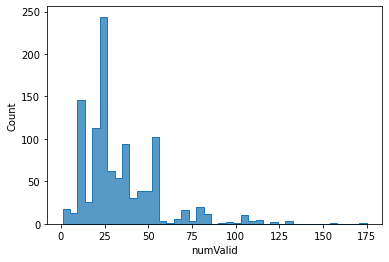

In [1342]:
# number of valid samples per plot
fig,ax = plt.subplots()
sns.histplot(samplesList[9], x='numValid',element="step")
plt.show()

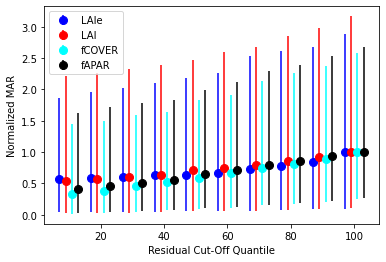

In [1343]:
# figure backup 1
# compares residuals as a function of quartile threshold used for selecting valid retrievals
x = np.array(range(10,110,10))
LAIeU50 = np.array(samplesLAIeU50)
LAIeU5 = np.array(samplesLAIeU50) - np.array(samplesLAIeU5) 
LAIeU95 = np.array(samplesLAIeU95) - np.array(samplesLAIeU50)

LAIU50 = np.array(samplesLAIU50)
LAIU5 = np.array(samplesLAIU50) - np.array(samplesLAIU5) 
LAIU95 = np.array(samplesLAIU95) - np.array(samplesLAIU50)

fCOVERU50 = np.array(samplesfCOVERU50)
fCOVERU5 = np.array(samplesfCOVERU50) - np.array(samplesfCOVERU5) 
fCOVERU95 = np.array(samplesfCOVERU95) - np.array(samplesfCOVERU50)

fAPARU50 = np.array(samplesfAPARU50)
fAPARU5 = np.array(samplesfAPARU50) - np.array(samplesfAPARU5) 
fAPARU95 = np.array(samplesfAPARU95) - np.array(samplesfAPARU50)

plt.errorbar(x-3, LAIeU50/LAIeU50[9],yerr=np.column_stack((LAIeU5/LAIeU50[9],LAIeU95/LAIeU50[9])).transpose(), ecolor='blue', marker='o', mfc='blue', mec='blue', ms=8, ls = 'none',label='LAIe')
plt.errorbar(x-1, LAIU50/LAIU50[9],yerr=np.column_stack((LAIU5/LAIU50[9],LAIU95/LAIU50[9])).transpose(), ecolor='red', marker='o', mfc='red', mec='red', ms=8, ls = 'none',label='LAI')
plt.errorbar(x+1, fCOVERU50/fCOVERU50[9],yerr=np.column_stack((fCOVERU5/fCOVERU50[9],fCOVERU95/fCOVERU50[9])).transpose(), ecolor='cyan',marker='o', mfc='cyan', mec='cyan', ms=8, ls = 'none',label='fCOVER')
plt.errorbar(x+3, fAPARU50/fAPARU50[9],yerr=np.column_stack((fAPARU5/fAPARU50[9],fAPARU95/fAPARU50[9])).transpose(), ecolor = 'black', marker='o', mfc='black', mec='black', ms=8, ls = 'none',label='fAPAR')
plt.xlabel('Residual Cut-Off Quantile')
plt.ylabel('Normalized MAR')
plt.legend(loc='upper left')



plt.show()

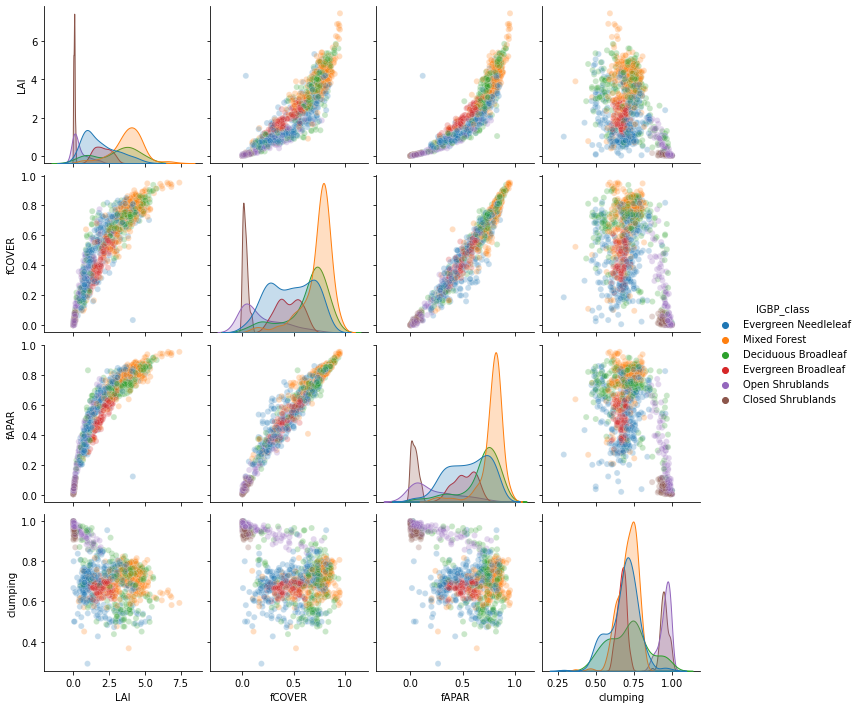

In [1344]:
# figure 2a  reference variables by IGBP
samplesDF = samplesList[4].rename(columns={'LAI_total':'LAI','fCOVER_total':'fCOVER','fAPAR_total':'fAPAR','clumping_total':'clumping',})
samplesDFfig1 = samplesDF[['LAI','fCOVER','fAPAR','clumping','IGBP_class']]
g = sns.pairplot(samplesDFfig1, hue='IGBP_class', markers= 'o',plot_kws={'alpha': 0.25})

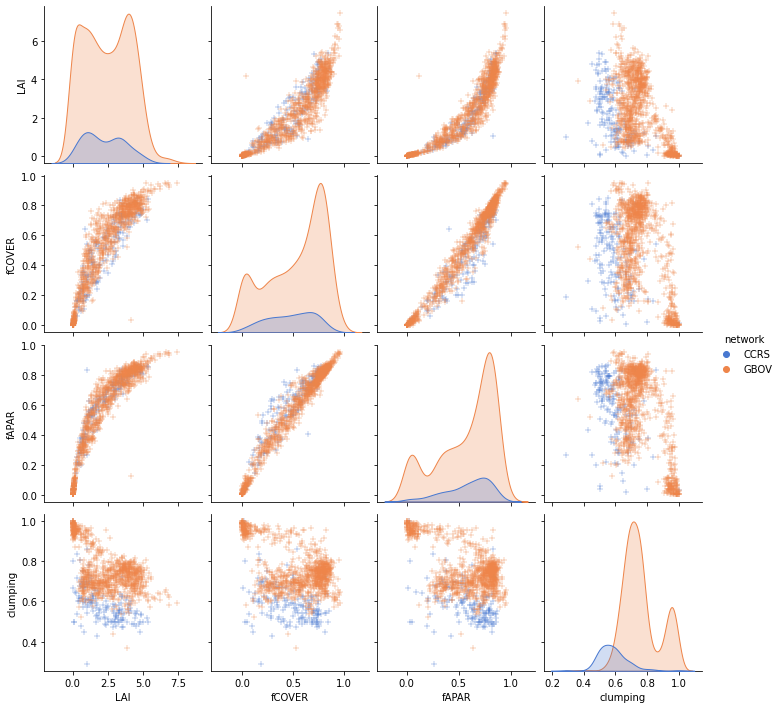

In [1345]:
# figure 2b  reference variables by network
samplesDF = samplesList[4].rename(columns={'LAI_total':'LAI','fCOVER_total':'fCOVER','fAPAR_total':'fAPAR','clumping_total':'clumping',})
samplesDFfig1 = samplesDF[['LAI','fCOVER','fAPAR','clumping','network']]
g = sns.pairplot(samplesDFfig1, hue='network', markers= '+',plot_kws={'alpha': 0.75},palette='muted')

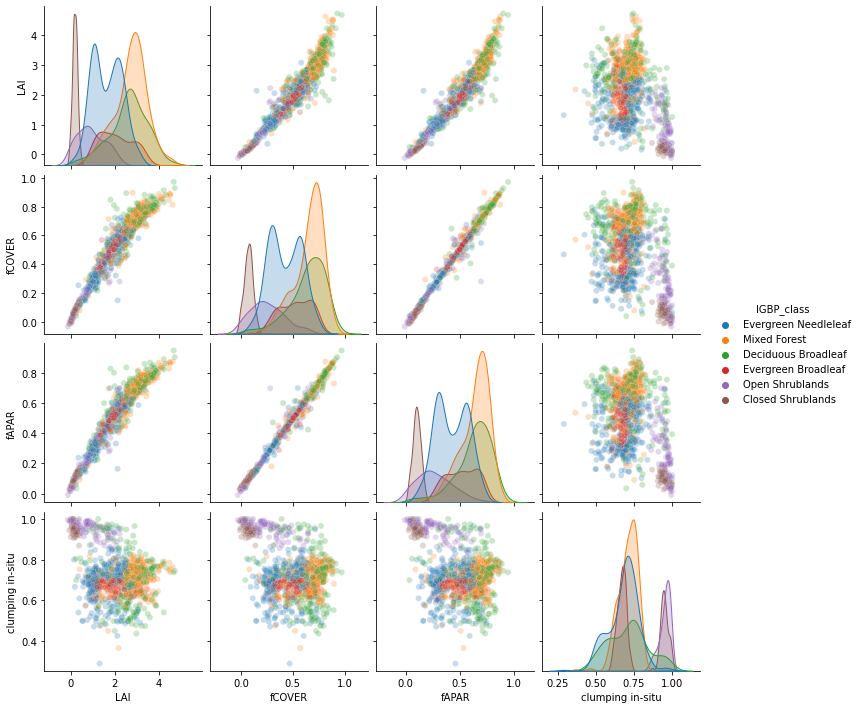

In [1346]:
# figure 3a sl2p variables by IGBP
samplesDF = samplesList[4].rename(columns={'LAI_PAIe_total_estimate':'LAI','fCOVER_fCOVER_total_estimate':'fCOVER','fAPAR_fAPAR_total_estimate':'fAPAR','clumping_total':'clumping in-situ'})
samplesDFfig1 = samplesDF[['LAI','fCOVER','fAPAR','clumping in-situ','IGBP_class']]
g = sns.pairplot(samplesDFfig1, hue='IGBP_class', markers= 'o',plot_kws={'alpha': 0.25})

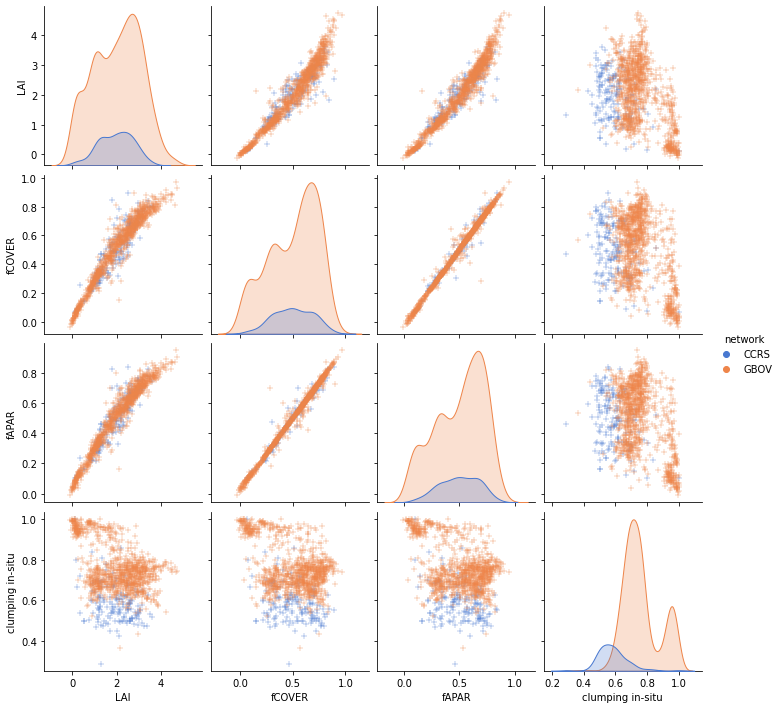

In [1347]:
# figure 3b sl2p variables by network
samplesDF = samplesList[4].rename(columns={'LAI_PAIe_total_estimate':'LAI','fCOVER_fCOVER_total_estimate':'fCOVER','fAPAR_fAPAR_total_estimate':'fAPAR','clumping_total':'clumping in-situ'})
samplesDFfig1 = samplesDF[['LAI','fCOVER','fAPAR','clumping in-situ','network']]
g = sns.pairplot(samplesDFfig1, hue='network', markers= '+',plot_kws={'alpha': 0.75},palette='muted')

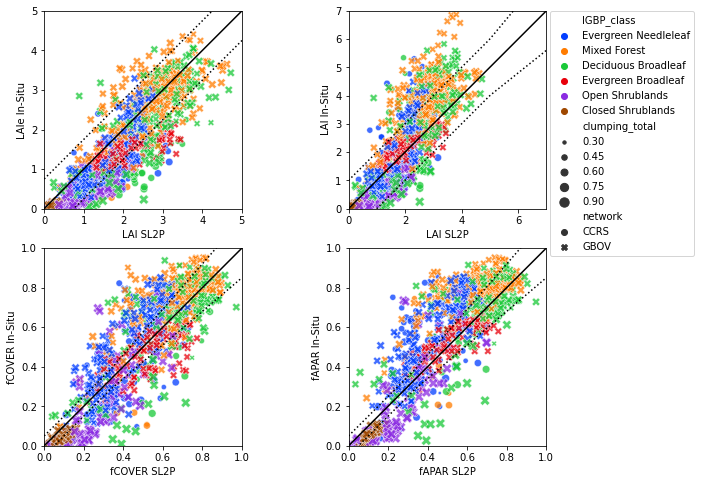

In [1348]:
# figure 4

fig, ax = plt.subplots(2,2)
fig.set_size_inches(10 ,8)
data = samplesList[4]


y = data['LAIe_total']
yerror = data['LAIe_total_err']
x = data['LAI_PAIe_total_estimate']
xerror = data['LAI_PAIe_total_err_estimate_mean'].astype('float')
# ax[0,0].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'or', ms=0, ecolor='grey',alpha=0.15)
sns.scatterplot(data=data, x='LAI_PAIe_total_estimate', y='LAIe_total', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 100), alpha=0.75,palette="bright", ax=ax[0,0],legend=False)
ax[0,0].plot(np.linspace(0,6,100),np.linspace(0,6,100)+np.maximum(np.linspace(0,6,100)*0.20*0.75,1*0.75),color='black',linestyle='dotted')
ax[0,0].plot(np.linspace(0,6,100),np.linspace(0,6,100)+np.minimum(-np.linspace(0,6,100)*0.20*0.75,-1*0.75),color='black',linestyle='dotted')
ax[0,0].plot([0,6],[0,6],color='black')
ax[0,0].set(adjustable='box',aspect='equal')
ax[0,0].set_ylabel('LAIe In-Situ')
ax[0,0].set_xlabel('LAI SL2P')


y = data['LAI_total']
yerror = data['LAI_total_err']
x = data['LAI_PAIe_total_estimate']
xerror = data['LAI_PAIe_total_err_estimate_mean'].astype('float')
# ax[0,1].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'or', ms=0, ecolor='grey',alpha=0.15)
sns.scatterplot(data=data, x='LAI_PAIe_total_estimate', y='LAI_total', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 100), alpha=.75, palette="bright", ax=ax[0,1])
ax[0,1].plot(np.linspace(0,7,100),np.linspace(0,7,100)+np.maximum(np.linspace(0,7,100)*0.20,1),color='black',linestyle='dotted')
ax[0,1].plot(np.linspace(0,7,100),np.linspace(0,7,100)+np.minimum(-np.linspace(0,7,100)*0.20,-1),color='black',linestyle='dotted')
ax[0,1].plot([0,7],[0,7],color='black')
ax[0,1].set(adjustable='box',aspect='equal')
ax[0,1].set_ylabel('LAI In-Situ')
ax[0,1].set_xlabel('LAI SL2P')

y = data['fCOVER_total']
yerror = data['fCOVER_total_err']
x = data['fCOVER_fCOVER_total_estimate']
xerror = data['fCOVER_fCOVER_total_err_estimate_mean'].astype('float')
# ax[1,0].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'or', ms=0, ecolor='grey',alpha=0.15)
ax[0,1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.scatterplot(data=data, x='fCOVER_fCOVER_total_estimate', y='fCOVER_total', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 100), alpha=.75, palette="bright", ax=ax[1,0],legend=False)
ax[1,0].plot(np.linspace(0,1,100),np.linspace(0,1,100)+np.maximum(np.linspace(0,1,100)*0.15,0.05),color='black',linestyle='dotted')
ax[1,0].plot(np.linspace(0,1,100),np.linspace(0,1,100)+np.minimum(-np.linspace(0,1,100)*0.15,-0.05),color='black',linestyle='dotted')
ax[1,0].plot([0,1],[0,1],color='black')
ax[1,0].set(adjustable='box',aspect='equal')
ax[1,0].set_ylabel('fCOVER In-Situ')
ax[1,0].set_xlabel('fCOVER SL2P')

y = data['fAPAR_total']
yerror = data['fAPAR_total_err']
x = data['fAPAR_fAPAR_total_estimate']
xerror = data['fAPAR_fAPAR_total_err_estimate_mean'].astype('float')
# ax[1,1].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'or', ms=0, ecolor='grey',alpha=0.15)
sns.scatterplot(data=data, x='fAPAR_fAPAR_total_estimate', y='fAPAR_total', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 100), alpha=.75, palette="bright", ax=ax[1,1],legend=False)
ax[1,1].plot(np.linspace(0,1,100),np.linspace(0,1,100)+np.maximum(np.linspace(0,1,100)*0.15,0.05),color='black',linestyle='dotted')
ax[1,1].plot(np.linspace(0,1,100),np.linspace(0,1,100)+np.minimum(-np.linspace(0,1,100)*0.15,-0.05),color='black',linestyle='dotted')
ax[1,1].plot([0,1],[0,1],color='black')
ax[1,1].set(adjustable='box',aspect='equal')
ax[1,1].set_ylabel('fAPAR In-Situ')
ax[1,1].set_xlabel('fAPAR SL2P')

ax[0,0].set_xlim([0,5])
ax[0,1].set_xlim([0,7])
ax[1,0].set_xlim([0,1])
ax[1,1].set_xlim([0,1])
ax[0,0].set_ylim([0,5])
ax[0,1].set_ylim([0,7])
ax[1,0].set_ylim([0,1])
ax[1,1].set_ylim([0,1])
plt.show()
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# data = samplesU50DF[samplesU50DF['network']=='GBOV']
# sns.scatterplot(data=data, x='LAI_PAIe_total_estimate', y='LAI_total', hue='IGBP_class',ax=ax)

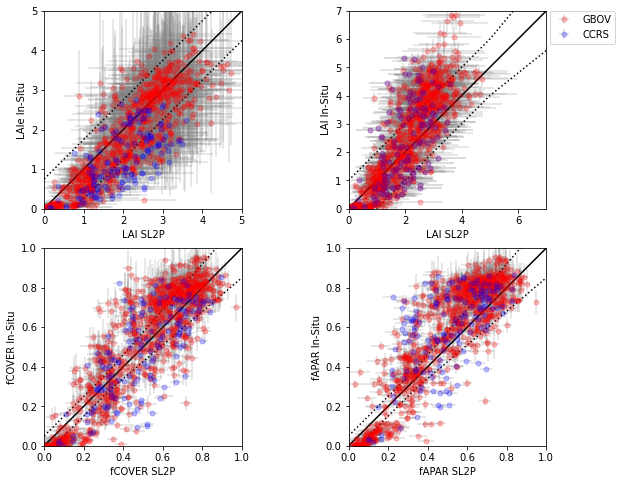

In [1349]:
# figure 6

fig, ax = plt.subplots(2,2)
fig.set_size_inches(10 ,8)
data = samplesList[4]


y = data.loc[data['network']=='GBOV','LAIe_total']
yerror = data.loc[data['network']=='GBOV','LAIe_total_err']
x = data.loc[data['network']=='GBOV','LAI_PAIe_total_estimate']
xerror = ((data.loc[data['network']=='GBOV','LAI_PAIe_total_estimate_std'].astype('float')).pow(2).divide(data.loc[data['network']=='GBOV','LAI_PAIe_total_estimate_count'].astype('float')).add(data.loc[data['network']=='GBOV','LAI_PAIe_total_err_estimate_mean'].astype('float').pow(2))).pow(0.5)
ax[0,0].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'or', ms=5, ecolor='grey',alpha=0.25,label='GBOV')
y = data.loc[data['network']=='CCRS','LAIe_total']
yerror = data.loc[data['network']=='CCRS','LAIe_total_err']
x = data.loc[data['network']=='CCRS','LAI_PAIe_total_estimate']
xerror = ((data.loc[data['network']=='CCRS','LAI_PAIe_total_estimate_std'].astype('float')).pow(2).divide(data.loc[data['network']=='CCRS','LAI_PAIe_total_estimate_count'].astype('float')).add(data.loc[data['network']=='CCRS','LAI_PAIe_total_err_estimate_mean'].astype('float').pow(2))).pow(0.5)
ax[0,0].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'ob', ms=5, ecolor='grey',alpha=0.25,label='CCRS')
#sns.scatterplot(data=data, x='LAI_PAIe_total_estimate', y='LAIe_total', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 100), alpha=0.75,palette="bright", ax=ax[0,0],legend=False)
ax[0,0].plot(np.linspace(0,6,100),np.linspace(0,6,100)+np.maximum(np.linspace(0,6,100)*0.20*0.75,1*0.75),color='black',linestyle='dotted')
ax[0,0].plot(np.linspace(0,6,100),np.linspace(0,6,100)+np.minimum(-np.linspace(0,6,100)*0.20*0.75,-1*0.75),color='black',linestyle='dotted')
ax[0,0].plot([0,6],[0,6],color='black')
ax[0,0].set(adjustable='box',aspect='equal')
ax[0,0].set_ylabel('LAIe In-Situ')
ax[0,0].set_xlabel('LAI SL2P')


y = data.loc[data['network']=='GBOV','LAI_total']
yerror = data.loc[data['network']=='GBOV','LAI_total_err']
x = data.loc[data['network']=='GBOV','LAI_PAIe_total_estimate']
xerror = ((data.loc[data['network']=='GBOV','LAI_PAIe_total_estimate_std'].astype('float')).pow(2).divide(data.loc[data['network']=='GBOV','LAI_PAIe_total_estimate_count'].astype('float')).add(data.loc[data['network']=='GBOV','LAI_PAIe_total_err_estimate_mean'].astype('float').pow(2))).pow(0.5)
ax[0,1].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'or', ms=5, ecolor='grey',alpha=0.25,label='GBOV')
y = data.loc[data['network']=='CCRS','LAI_total']
yerror = data.loc[data['network']=='CCRS','LAI_total_err']
x = data.loc[data['network']=='CCRS','LAI_PAIe_total_estimate']
xerror = ((data.loc[data['network']=='CCRS','LAI_PAIe_total_estimate_std'].astype('float')).pow(2).divide(data.loc[data['network']=='CCRS','LAI_PAIe_total_estimate_count'].astype('float')).add(data.loc[data['network']=='CCRS','LAI_PAIe_total_err_estimate_mean'].astype('float').pow(2))).pow(0.5)
ax[0,1].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'ob', ms=5, ecolor='grey',alpha=0.25,label='CCRS')
ax[0,1].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'or', ms=5, ecolor='grey',alpha=0.15)
#sns.scatterplot(data=data, x='LAI_PAIe_total_estimate', y='LAI_total', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 100), alpha=.75, palette="bright", ax=ax[0,1])
ax[0,1].plot(np.linspace(0,7,100),np.linspace(0,7,100)+np.maximum(np.linspace(0,7,100)*0.20,1),color='black',linestyle='dotted')
ax[0,1].plot(np.linspace(0,7,100),np.linspace(0,7,100)+np.minimum(-np.linspace(0,7,100)*0.20,-1),color='black',linestyle='dotted')
ax[0,1].plot([0,7],[0,7],color='black')
ax[0,1].set(adjustable='box',aspect='equal')
ax[0,1].set_ylabel('LAI In-Situ')
ax[0,1].set_xlabel('LAI SL2P')

y = data.loc[data['network']=='GBOV','fCOVER_total']
yerror = data.loc[data['network']=='GBOV','fCOVER_total_err']
x = data.loc[data['network']=='GBOV','fCOVER_fCOVER_total_estimate']
xerror = ((data.loc[data['network']=='GBOV','fCOVER_fCOVER_total_estimate_std'].astype('float')).pow(2).divide(data.loc[data['network']=='GBOV','fCOVER_fCOVER_total_estimate_count'].astype('float')).add(data.loc[data['network']=='GBOV','fCOVER_fCOVER_total_err_estimate_mean'].astype('float').pow(2))).pow(0.5)
ax[1,0].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'or', ms=5, ecolor='grey',alpha=0.25,label='GBOV')
y = data.loc[data['network']=='CCRS','fCOVER_total']
yerror = data.loc[data['network']=='CCRS','fCOVER_total_err']
x = data.loc[data['network']=='CCRS','fCOVER_fCOVER_total_estimate']
xerror = ((data.loc[data['network']=='CCRS','fCOVER_fCOVER_total_estimate_std'].astype('float')).pow(2).divide(data.loc[data['network']=='CCRS','fCOVER_fCOVER_total_estimate_count'].astype('float')).add(data.loc[data['network']=='CCRS','fCOVER_fCOVER_total_err_estimate_mean'].astype('float').pow(2))).pow(0.5)
ax[1,0].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'ob', ms=5, ecolor='grey',alpha=0.25,label='CCRS')
# ax[0,1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
#sns.scatterplot(data=data, x='fCOVER_fCOVER_total_estimate', y='fCOVER_total', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 100), alpha=.75, palette="bright", ax=ax[1,0],legend=False)
ax[1,0].plot(np.linspace(0,1,100),np.linspace(0,1,100)+np.maximum(np.linspace(0,1,100)*0.15,0.05),color='black',linestyle='dotted')
ax[1,0].plot(np.linspace(0,1,100),np.linspace(0,1,100)+np.minimum(-np.linspace(0,1,100)*0.15,-0.05),color='black',linestyle='dotted')
ax[1,0].plot([0,1],[0,1],color='black')
ax[1,0].set(adjustable='box',aspect='equal')
ax[1,0].set_ylabel('fCOVER In-Situ')
ax[1,0].set_xlabel('fCOVER SL2P')

y = data.loc[data['network']=='GBOV','fAPAR_total']
yerror = data.loc[data['network']=='GBOV','fAPAR_total_err']
x = data.loc[data['network']=='GBOV','fAPAR_fAPAR_total_estimate']
xerror = ((data.loc[data['network']=='GBOV','fAPAR_fAPAR_total_estimate_std'].astype('float')).pow(2).divide(data.loc[data['network']=='GBOV','fAPAR_fAPAR_total_estimate_count'].astype('float')).add(data.loc[data['network']=='GBOV','fAPAR_fAPAR_total_err_estimate_mean'].astype('float').pow(2))).pow(0.5)
ax[1,1].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'or', ms=5, ecolor='grey',alpha=0.25,label='GBOV')
y = data.loc[data['network']=='CCRS','fAPAR_total']
yerror = data.loc[data['network']=='CCRS','fAPAR_total_err']
x = data.loc[data['network']=='CCRS','fAPAR_fAPAR_total_estimate']
xerror = ((data.loc[data['network']=='CCRS','fAPAR_fAPAR_total_estimate_std'].astype('float')).pow(2).divide(data.loc[data['network']=='CCRS','fAPAR_fAPAR_total_estimate_count'].astype('float')).add(data.loc[data['network']=='CCRS','fAPAR_fAPAR_total_err_estimate_mean'].astype('float').pow(2))).pow(0.5)
ax[1,1].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'ob', ms=5, ecolor='grey',alpha=0.25,label='CCRS')

#sns.scatterplot(data=data, x='fAPAR_fAPAR_total_estimate', y='fAPAR_total', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 100), alpha=.75, palette="bright", ax=ax[1,1],legend=False)
ax[1,1].plot(np.linspace(0,1,100),np.linspace(0,1,100)+np.maximum(np.linspace(0,1,100)*0.15,0.05),color='black',linestyle='dotted')
ax[1,1].plot(np.linspace(0,1,100),np.linspace(0,1,100)+np.minimum(-np.linspace(0,1,100)*0.15,-0.05),color='black',linestyle='dotted')
ax[1,1].plot([0,1],[0,1],color='black')
ax[1,1].set(adjustable='box',aspect='equal')
ax[1,1].set_ylabel('fAPAR In-Situ')
ax[1,1].set_xlabel('fAPAR SL2P')

ax[0,0].set_xlim([0,5])
ax[0,1].set_xlim([0,7])
ax[1,0].set_xlim([0,1])
ax[1,1].set_xlim([0,1])
ax[0,0].set_ylim([0,5])
ax[0,1].set_ylim([0,7])
ax[1,0].set_ylim([0,1])
ax[1,1].set_ylim([0,1])
ax[0,1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

# data = samplesU50DF[samplesU50DF['network']=='GBOV']
# sns.scatterplot(data=data, x='LAI_PAIe_total_estimate', y='LAI_total', hue='IGBP_class',ax=ax)

Text(0.5, 0, 'COVER SL2P Theoretical Precision')

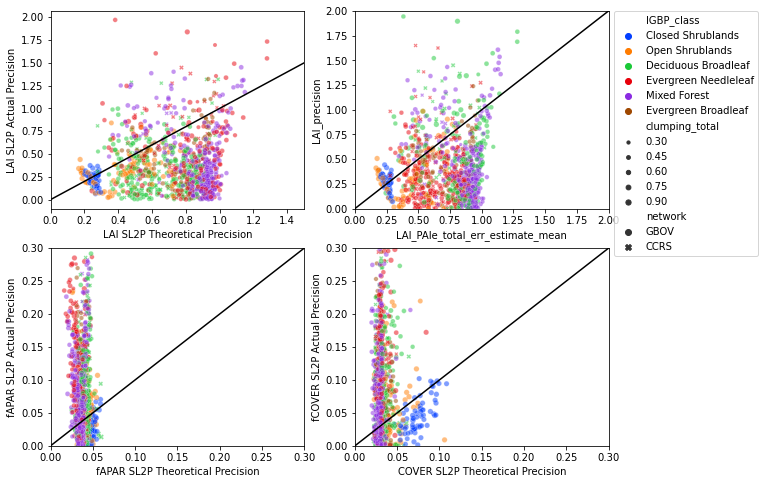

In [1350]:
# figure 5
import numpy.polynomial.chebyshev as cheb
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(10, 8)

percentileToPlot = 4

#LAIe
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAIe_total'] = data['LAIe_total'].add(randomDF['randomCol'])
data = data.sort_values('LAIe_total')
data['LAIe_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAIe_total']))
y = np.array(data['LAIe_residual'])
x = np.array(data['LAIe_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAIe_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
accCheb= cheb.Chebyshev.fit(x, y,3,window=[np.amin(x), np.amax(x)])
unc = abs(y)
uncCheb= cheb.Chebyshev.fit(x,unc,3,window=[np.amin(x), np.amax(x)])
pre = abs(y-(cheb.chebval(x,accCheb.coef)))
preCheb= cheb.Chebyshev.fit(x, pre,3,window=[np.amin(x), np.amax(x)])

data['LAIe_precision'] = pre
sns.scatterplot(data=data, x='LAI_PAIe_total_err_estimate_mean', y='LAIe_precision', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 30), alpha=.5, palette="bright", ax=ax[0,0],legend=False)
ax[0,0].plot(np.linspace(0,1.5,100),np.linspace(0,1.5,100),color='black')
ax[0,1].set_ylim([0,1.5])
ax[0,0].set_xlim([0,1.5])
ax[0,0].set_ylabel('LAIe SL2P Actual Precision')
ax[0,0].set_xlabel('LAI SL2P Theoretical Precision')


#LAI
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAI_total'] = data['LAI_total'].add(randomDF['randomCol'])
data = data.sort_values('LAI_total')
data['LAI_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAI_total']))
y = np.array(data['LAI_residual'])
x = np.array(data['LAI_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAI_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
accCheb= cheb.Chebyshev.fit(x, y,3,window=[np.amin(x), np.amax(x)])
unc = abs(y)
uncCheb= cheb.Chebyshev.fit(x,unc,3,window=[np.amin(x), np.amax(x)])
pre = abs(y-(cheb.chebval(x,accCheb.coef)))
preCheb= cheb.Chebyshev.fit(x, pre,3,window=[np.amin(x), np.amax(x)])

data['LAI_precision'] = pre
sns.scatterplot(data=data, x='LAI_PAIe_total_err_estimate_mean', y='LAI_precision', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 30), alpha=.5, palette="bright", ax=ax[0,1],legend=True)
ax[0,1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax[0,1].plot(np.linspace(0,2,100),np.linspace(0,2,100),color='black')
ax[0,1].set_ylim([0,2])
ax[0,1].set_xlim([0,2])
ax[0,0].set_ylabel('LAI SL2P Actual Precision')
ax[0,0].set_xlabel('LAI SL2P Theoretical Precision')

#fAPAR
data = samplesList[percentileToPlot]
data = data[~data['fAPAR_fAPAR_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fAPAR_total'] = data['fAPAR_total'].add(randomDF['randomCol'])


data['fAPAR_residual'] = data['fAPAR_fAPAR_total_estimate'].sub((data['fAPAR_total']))
data = data.sort_values(['fAPAR_total'])

y = np.array(data['fAPAR_residual'])
x = np.array(data['fAPAR_total'])
err =np.array(((data['fAPAR_fAPAR_total_err_estimate_mean']).pow(2).add((data['fAPAR_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
accCheb= cheb.Chebyshev.fit(x, y,3,window=[np.amin(x), np.amax(x)])
unc = abs(y)
uncCheb= cheb.Chebyshev.fit(x,unc,3,window=[np.amin(x), np.amax(x)])
pre = abs(y-(cheb.chebval(x,accCheb.coef)))
preCheb= cheb.Chebyshev.fit(x, pre,3,window=[np.amin(x), np.amax(x)])
data['fAPAR_precision'] = pre


sns.scatterplot(data=data, x='fAPAR_fAPAR_total_err_estimate_mean', y='fAPAR_precision', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10,30), alpha=.5, palette="bright", ax=ax[1,0],legend=False)
ax[1,0].plot(np.linspace(0,.3,100),np.linspace(0,.3,100),color='black')
ax[1,0].set_ylim([0,.3])
ax[1,0].set_xlim([0,.3])
ax[1,0].set_ylabel('fAPAR SL2P Actual Precision')
ax[1,0].set_xlabel('fAPAR SL2P Theoretical Precision')


#fCOVER
data = samplesList[percentileToPlot]
data = data[~data['fCOVER_fCOVER_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fCOVER_total'] = data['fCOVER_total'].add(randomDF['randomCol'])
data['fCOVER_residual'] = data['fCOVER_fCOVER_total_estimate'].sub((data['fCOVER_total']))
data = data.sort_values(['fCOVER_total'])

y = np.array(data['fCOVER_residual'])
x = np.array(data['fCOVER_total'])
err =np.array(((data['fCOVER_fCOVER_total_err_estimate_mean']).pow(2).add((data['fCOVER_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
accCheb= cheb.Chebyshev.fit(x, y,3,window=[np.amin(x), np.amax(x)])
unc = abs(y)
uncCheb= cheb.Chebyshev.fit(x,unc,3,window=[np.amin(x), np.amax(x)])
pre = abs(y-(cheb.chebval(x,accCheb.coef)))
preCheb= cheb.Chebyshev.fit(x, pre,3,window=[np.amin(x), np.amax(x)])
data['fCOVER_precision']=pre

sns.scatterplot(data=data, x='fCOVER_fCOVER_total_err_estimate_mean', y='fCOVER_precision', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 30), alpha=.5, palette="bright", ax=ax[1,1],legend=False)
ax[1,1].plot(np.linspace(0,.3,100),np.linspace(0,.3,100),color='black')
ax[1,1].set_ylim([0,.3])
ax[1,1].set_xlim([0,.3])
ax[1,1].set_ylabel('fCOVER SL2P Actual Precision')
ax[1,1].set_xlabel('COVER SL2P Theoretical Precision')


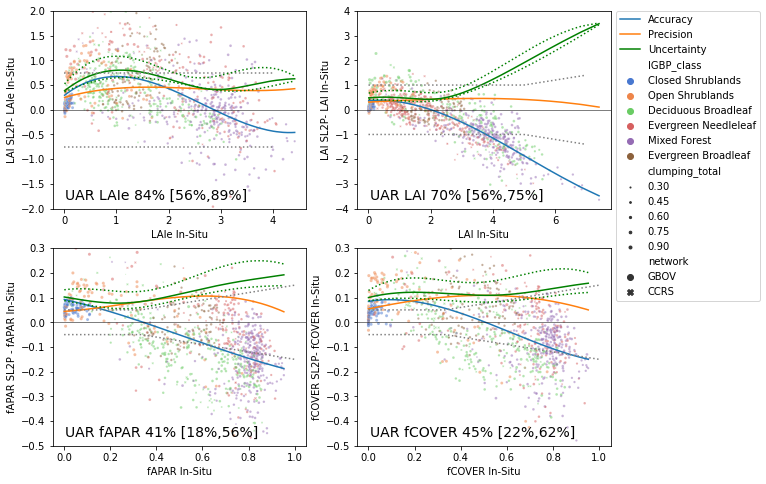

In [1351]:
# figure 5
import numpy.polynomial.chebyshev as cheb
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(10, 8)

percentileToPlot = 4

#LAIe
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAIe_total'] = data['LAIe_total'].add(randomDF['randomCol'])
data = data.sort_values('LAIe_total')
data['LAIe_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAIe_total']))
y = np.array(data['LAIe_residual'])
x = np.array(data['LAIe_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAIe_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
accCheb= cheb.Chebyshev.fit(x, y,3,window=[np.amin(x), np.amax(x)])
unc = abs(y)
uncCheb= cheb.Chebyshev.fit(x,unc,3,window=[np.amin(x), np.amax(x)])
pre = abs(y-(cheb.chebval(x,accCheb.coef)))
preCheb= cheb.Chebyshev.fit(x, pre,3,window=[np.amin(x), np.amax(x)])


ax[0,0].plot(x, cheb.chebval(x,accCheb.coef), label='Accuracy')
ax[0,0].plot(x,cheb.chebval(x,preCheb.coef), label='Precision')
ax[0,0].plot(x,(cheb.chebval(x,preCheb.coef)**2 + cheb.chebval(x,accCheb.coef) ** 2 ) ** (0.5), label='Uncertainty',color='g')

sns.scatterplot(data=data, x='LAIe_total', y='LAIe_residual', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(1, 10), alpha=.5, palette="muted", ax=ax[0,0],legend=False)
ax[0,0].plot(np.linspace(0,4,100),np.maximum(np.linspace(0,4,100)*0.2*0.75,1*0.75),color='grey',linestyle='dotted')
ax[0,0].plot(np.linspace(0,4,100),np.minimum(-np.linspace(0,4,100)*0.2*0.75,-1*0.75),color='grey',linestyle='dotted')
ax[0,0].axhline(y=0,color='black',linewidth=0.5)
ax[0,0].set_ylim([-2,2])
ax[0,0].set_ylabel('LAI SL2P- LAIe In-Situ')
ax[0,0].set_xlabel('LAIe In-Situ')
uarLAIemid = np.sum(np.abs(y)<np.maximum(x*0.2,1))/y.size

#LAI
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAI_total'] = data['LAI_total'].add(randomDF['randomCol'])
data = data.sort_values('LAI_total')
data['LAI_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAI_total']))
y = np.array(data['LAI_residual'])
x = np.array(data['LAI_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAI_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
accCheb= cheb.Chebyshev.fit(x, y,3,window=[np.amin(x), np.amax(x)])
unc = abs(y)
uncCheb= cheb.Chebyshev.fit(x,unc,3,window=[np.amin(x), np.amax(x)])
pre = abs(y-(cheb.chebval(x,accCheb.coef)))
preCheb= cheb.Chebyshev.fit(x, pre,3,window=[np.amin(x), np.amax(x)])


ax[0,1].plot(x, cheb.chebval(x,accCheb.coef), label='Accuracy')
ax[0,1].plot(x,cheb.chebval(x,preCheb.coef), label='Precision')
ax[0,1].plot(x,(cheb.chebval(x,preCheb.coef)**2 + cheb.chebval(x,accCheb.coef) ** 2 ) ** (0.5), label='Uncertainty',color='g')

sns.scatterplot(data=data, x='LAI_total', y='LAI_residual', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(1, 10), alpha=.5, palette="muted", ax=ax[0,1],legend=True)
ax[0,1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax[0,1].plot(np.linspace(0,7,100),np.maximum(np.linspace(0,7,100)*0.2,1),color='grey',linestyle='dotted')
ax[0,1].plot(np.linspace(0,7,100),np.minimum(-np.linspace(0,7,100)*0.2,-1),color='grey',linestyle='dotted')
ax[0,1].axhline(y=0,color='black',linewidth=0.5)
ax[0,1].set_ylim([-4,4])
ax[0,1].set_ylabel('LAI SL2P- LAI In-Situ')
ax[0,1].set_xlabel('LAI In-Situ')
uarLAImid = np.sum(np.abs(y)<np.maximum(x*0.2,1))/y.size

#fAPAR
data = samplesList[percentileToPlot]
data = data[~data['fAPAR_fAPAR_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fAPAR_total'] = data['fAPAR_total'].add(randomDF['randomCol'])


data['fAPAR_residual'] = data['fAPAR_fAPAR_total_estimate'].sub((data['fAPAR_total']))
data = data.sort_values(['fAPAR_total'])

y = np.array(data['fAPAR_residual'])
x = np.array(data['fAPAR_total'])
err =np.array(((data['fAPAR_fAPAR_total_err_estimate_mean']).pow(2).add((data['fAPAR_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
accCheb= cheb.Chebyshev.fit(x, y,3,window=[np.amin(x), np.amax(x)])
unc = abs(y)
uncCheb= cheb.Chebyshev.fit(x,unc,3,window=[np.amin(x), np.amax(x)])
pre = abs(y-(cheb.chebval(x,accCheb.coef)))
preCheb= cheb.Chebyshev.fit(x, pre,3,window=[np.amin(x), np.amax(x)])



ax[1,0].plot(x, cheb.chebval(x,accCheb.coef), label='Accuracy')
ax[1,0].plot(x,cheb.chebval(x,preCheb.coef), label='Precision')
ax[1,0].plot(x,(cheb.chebval(x,preCheb.coef)**2 + cheb.chebval(x,accCheb.coef) ** 2 ) ** (0.5), label='Uncertainty',color='g')

sns.scatterplot(data=data, x='fAPAR_total', y='fAPAR_residual', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(1, 10), alpha=.5, palette="muted", ax=ax[1,0],legend=False)
ax[1,0].plot(np.linspace(0,1,100),np.maximum(np.linspace(0,1,100)*0.15,0.05),color='grey',linestyle='dotted')
ax[1,0].plot(np.linspace(0,1,100),np.minimum(-np.linspace(0,1,100)*0.15,-0.05),color='grey',linestyle='dotted')
ax[1,0].axhline(y=0,color='black',linewidth=0.5)
ax[1,0].set_ylim([-0.5,0.3])
ax[1,0].set_ylabel('fAPAR SL2P - fAPAR In-Situ')
ax[1,0].set_xlabel('fAPAR In-Situ')
uarfAPARmid = np.sum(np.abs(y)<np.maximum(x*0.15,0.05))/y.size

#fCOVER
data = samplesList[percentileToPlot]
data = data[~data['fCOVER_fCOVER_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fCOVER_total'] = data['fCOVER_total'].add(randomDF['randomCol'])
data['fCOVER_residual'] = data['fCOVER_fCOVER_total_estimate'].sub((data['fCOVER_total']))
data = data.sort_values(['fCOVER_total'])

y = np.array(data['fCOVER_residual'])
x = np.array(data['fCOVER_total'])
err =np.array(((data['fCOVER_fCOVER_total_err_estimate_mean']).pow(2).add((data['fCOVER_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
accCheb= cheb.Chebyshev.fit(x, y,3,window=[np.amin(x), np.amax(x)])
unc = abs(y)
uncCheb= cheb.Chebyshev.fit(x,unc,3,window=[np.amin(x), np.amax(x)])
pre = abs(y-(cheb.chebval(x,accCheb.coef)))
preCheb= cheb.Chebyshev.fit(x, pre,3,window=[np.amin(x), np.amax(x)])


ax[1,1].plot(x, cheb.chebval(x,accCheb.coef), label='Accuracy')
ax[1,1].plot(x,cheb.chebval(x,preCheb.coef), label='Precision')
ax[1,1].plot(x,(cheb.chebval(x,preCheb.coef)**2 + cheb.chebval(x,accCheb.coef) ** 2 ) ** (0.5), label='Uncertainty',color='g')

sns.scatterplot(data=data, x='fCOVER_total', y='fCOVER_residual', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(1, 10), alpha=.5, palette="muted", ax=ax[1,1],legend=False)
ax[1,1].plot(np.linspace(0,1,100),np.maximum(np.linspace(0,1,100)*0.15,0.05),color='grey',linestyle='dotted')
ax[1,1].plot(np.linspace(0,1,100),np.minimum(-np.linspace(0,1,100)*0.15,-0.05),color='grey',linestyle='dotted')
ax[1,1].axhline(y=0,color='black',linewidth=0.5)
ax[1,1].set_ylim([-0.5,0.3])
ax[1,1].set_ylabel('fCOVER SL2P- fCOVER In-Situ')
ax[1,1].set_xlabel('fCOVER In-Situ')
uarfCOVERmid = np.sum(np.abs(y)<np.maximum(x*0.15,0.05))/y.size

percentileToPlot = 1

#LAIe
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAIe_total'] = data['LAIe_total'].add(randomDF['randomCol'])
data = data.sort_values('LAIe_total')
data['LAIe_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAIe_total']))
y = np.array(data['LAIe_residual'])
x = np.array(data['LAIe_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAIe_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
accCheb= cheb.Chebyshev.fit(x, y,3,window=[np.amin(x), np.amax(x)])
unc = abs(y)
uncCheb= cheb.Chebyshev.fit(x,unc,3,window=[np.amin(x), np.amax(x)])
pre = abs(y-(cheb.chebval(x,accCheb.coef)))
preCheb= cheb.Chebyshev.fit(x, pre,3,window=[np.amin(x), np.amax(x)])


ax[0,0].plot(x,(cheb.chebval(x,preCheb.coef)**2 + cheb.chebval(x,accCheb.coef) ** 2 ) ** (0.5), label='Uncertainty',linestyle='dotted',color='green')

uarLAIelow= np.sum(np.abs(y)<np.maximum(x*0.2,1))/y.size

#LAI
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAI_total'] = data['LAI_total'].add(randomDF['randomCol'])
data = data.sort_values('LAI_total')
data['LAI_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAI_total']))
y = np.array(data['LAI_residual'])
x = np.array(data['LAI_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAI_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
accCheb= cheb.Chebyshev.fit(x, y,3,window=[np.amin(x), np.amax(x)])
unc = abs(y)
uncCheb= cheb.Chebyshev.fit(x,unc,3,window=[np.amin(x), np.amax(x)])
pre = abs(y-(cheb.chebval(x,accCheb.coef)))
preCheb= cheb.Chebyshev.fit(x, pre,3,window=[np.amin(x), np.amax(x)])


ax[0,1].plot(x,(cheb.chebval(x,preCheb.coef)**2 + cheb.chebval(x,accCheb.coef) ** 2 ) ** (0.5), label='Uncertainty',linestyle='dotted',color='green')
uarLAIlow = np.sum(np.abs(y)<np.maximum(x*0.2,1))/y.size

#fAPAR
data = samplesList[percentileToPlot]
data = data[~data['fAPAR_fAPAR_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fAPAR_total'] = data['fAPAR_total'].add(randomDF['randomCol'])


data['fAPAR_residual'] = data['fAPAR_fAPAR_total_estimate'].sub((data['fAPAR_total']))
data = data.sort_values(['fAPAR_total'])

y = np.array(data['fAPAR_residual'])
x = np.array(data['fAPAR_total'])
err =np.array(((data['fAPAR_fAPAR_total_err_estimate_mean']).pow(2).add((data['fAPAR_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
accCheb= cheb.Chebyshev.fit(x, y,3,window=[np.amin(x), np.amax(x)])
unc = abs(y)
uncCheb= cheb.Chebyshev.fit(x,unc,3,window=[np.amin(x), np.amax(x)])
pre = abs(y-(cheb.chebval(x,accCheb.coef)))
preCheb= cheb.Chebyshev.fit(x, pre,3,window=[np.amin(x), np.amax(x)])

ax[1,0].plot(x,(cheb.chebval(x,preCheb.coef)**2 + cheb.chebval(x,accCheb.coef) ** 2 ) ** (0.5), label='Uncertainty',linestyle='dotted',color='green')

uarfAPARlow = np.sum(np.abs(y)<np.maximum(x*0.15,0.05))/y.size

#fCOVER
data = samplesList[percentileToPlot]
data = data[~data['fCOVER_fCOVER_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fCOVER_total'] = data['fCOVER_total'].add(randomDF['randomCol'])
data['fCOVER_residual'] = data['fCOVER_fCOVER_total_estimate'].sub((data['fCOVER_total']))
data = data.sort_values(['fCOVER_total'])

y = np.array(data['fCOVER_residual'])
x = np.array(data['fCOVER_total'])
err =np.array(((data['fCOVER_fCOVER_total_err_estimate_mean']).pow(2).add((data['fCOVER_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
accCheb= cheb.Chebyshev.fit(x, y,3,window=[np.amin(x), np.amax(x)])
unc = abs(y)
uncCheb= cheb.Chebyshev.fit(x,unc,3,window=[np.amin(x), np.amax(x)])
pre = abs(y-(cheb.chebval(x,accCheb.coef)))
preCheb= cheb.Chebyshev.fit(x, pre,3,window=[np.amin(x), np.amax(x)])


ax[1,1].plot(x,(cheb.chebval(x,preCheb.coef)**2 + cheb.chebval(x,accCheb.coef) ** 2 ) ** (0.5), label='Uncertainty',linestyle='dotted',color='green')
uarfCOVERlow = np.sum(np.abs(y)<np.maximum(x*0.15,0.05))/y.size

percentileToPlot = 9

#LAIe
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAIe_total'] = data['LAIe_total'].add(randomDF['randomCol'])
data = data.sort_values('LAIe_total')
data['LAIe_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAIe_total']))
y = np.array(data['LAIe_residual'])
x = np.array(data['LAIe_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAIe_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
accCheb= cheb.Chebyshev.fit(x, y,3,window=[np.amin(x), np.amax(x)])
unc = abs(y)
uncCheb= cheb.Chebyshev.fit(x,unc,3,window=[np.amin(x), np.amax(x)])
pre = abs(y-(cheb.chebval(x,accCheb.coef)))
preCheb= cheb.Chebyshev.fit(x, pre,3,window=[np.amin(x), np.amax(x)])


ax[0,0].plot(x,(cheb.chebval(x,preCheb.coef)**2 + cheb.chebval(x,accCheb.coef) ** 2 ) ** (0.5), label='Uncertainty',linestyle='dotted',color='green')

uarLAIehigh= np.sum(np.abs(y)<np.maximum(x*0.2,1))/y.size

#LAI
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAI_total'] = data['LAI_total'].add(randomDF['randomCol'])
data = data.sort_values('LAI_total')
data['LAI_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAI_total']))
y = np.array(data['LAI_residual'])
x = np.array(data['LAI_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAI_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
accCheb= cheb.Chebyshev.fit(x, y,3,window=[np.amin(x), np.amax(x)])
unc = abs(y)
uncCheb= cheb.Chebyshev.fit(x,unc,3,window=[np.amin(x), np.amax(x)])
pre = abs(y-(cheb.chebval(x,accCheb.coef)))
preCheb= cheb.Chebyshev.fit(x, pre,3,window=[np.amin(x), np.amax(x)])

ax[0,1].plot(x,(cheb.chebval(x,preCheb.coef)**2 + cheb.chebval(x,accCheb.coef) ** 2 ) ** (0.5), label='Uncertainty',linestyle='dotted',color='green')
uarLAIhigh = np.sum(np.abs(y)<np.maximum(x*0.2,1))/y.size

#fAPAR
data = samplesList[percentileToPlot]
data = data[~data['fAPAR_fAPAR_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fAPAR_total'] = data['fAPAR_total'].add(randomDF['randomCol'])


data['fAPAR_residual'] = data['fAPAR_fAPAR_total_estimate'].sub((data['fAPAR_total']))
data = data.sort_values(['fAPAR_total'])

y = np.array(data['fAPAR_residual'])
x = np.array(data['fAPAR_total'])
err =np.array(((data['fAPAR_fAPAR_total_err_estimate_mean']).pow(2).add((data['fAPAR_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
accCheb= cheb.Chebyshev.fit(x, y,3,window=[np.amin(x), np.amax(x)])
unc = abs(y)
uncCheb= cheb.Chebyshev.fit(x,unc,3,window=[np.amin(x), np.amax(x)])
pre = abs(y-(cheb.chebval(x,accCheb.coef)))
preCheb= cheb.Chebyshev.fit(x, pre,3,window=[np.amin(x), np.amax(x)])

ax[1,0].plot(x,(cheb.chebval(x,preCheb.coef)**2 + cheb.chebval(x,accCheb.coef) ** 2 ) ** (0.5), label='Uncertainty',linestyle='dotted',color='green')

uarfAPARhigh = np.sum(np.abs(y)<np.maximum(x*0.15,0.05))/y.size

#fCOVER
data = samplesList[percentileToPlot]
data = data[~data['fCOVER_fCOVER_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fCOVER_total'] = data['fCOVER_total'].add(randomDF['randomCol'])
data['fCOVER_residual'] = data['fCOVER_fCOVER_total_estimate'].sub((data['fCOVER_total']))
data = data.sort_values(['fCOVER_total'])

y = np.array(data['fCOVER_residual'])
x = np.array(data['fCOVER_total'])
err =np.array(((data['fCOVER_fCOVER_total_err_estimate_mean']).pow(2).add((data['fCOVER_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
accCheb= cheb.Chebyshev.fit(x, y,3,window=[np.amin(x), np.amax(x)])
unc = abs(y)
uncCheb= cheb.Chebyshev.fit(x,unc,3,window=[np.amin(x), np.amax(x)])
pre = abs(y-(cheb.chebval(x,accCheb.coef)))
preCheb= cheb.Chebyshev.fit(x, pre,3,window=[np.amin(x), np.amax(x)])


ax[1,1].plot(x,(cheb.chebval(x,preCheb.coef)**2 + cheb.chebval(x,accCheb.coef) ** 2 ) ** (0.5), label='Uncertainty',linestyle='dotted',color='green')
uarfCOVERhigh = np.sum(np.abs(y)<np.maximum(x*0.15,0.05))/y.size


#annotate subplots with stats
ax[0,0].text(0.05, 0.1, 'UAR LAIe ' + str(int(uarLAIemid*100)) + '% ['+str(int(uarLAIhigh*100))+'%,'+str(int(uarLAIelow*100))+'%]', transform=ax[0,0].transAxes, fontsize=14,verticalalignment='top')
ax[0,1].text(0.05, 0.1, 'UAR LAI ' + str(int(uarLAImid*100)) + '% ['+str(int(uarLAIhigh*100))+'%,'+str(int(uarLAIlow*100))+'%]', transform=ax[0,1].transAxes, fontsize=14,verticalalignment='top')
ax[1,0].text(0.05, 0.1, 'UAR fAPAR ' + str(int(uarfAPARmid*100)) + '% ['+str(int(uarfAPARhigh*100))+'%,'+str(int(uarfAPARlow*100))+'%]', transform=ax[1,0].transAxes, fontsize=14,verticalalignment='top')
ax[1,1].text(0.05, 0.1, 'UAR fCOVER ' + str(int(uarfCOVERmid*100)) + '% ['+str(int(uarfCOVERhigh*100))+'%,'+str(int(uarfCOVERlow*100))+'%]', transform=ax[1,1].transAxes, fontsize=14,verticalalignment='top')

plt.show()

In [1401]:
samplesDF = samplesList[4]
# summary stats of in-situ data includ those with no match ups and then keep only those wioth matchups
#print('Total in-situ samples per network:',samplesDF.groupby('network').count()['numSamples'])
#print('Total in-situ samples per site:',samplesDF.groupby('Site').count()['numSamples'])
#print('Total in-situ samples per site:',samplesDF.groupby('Site').first()['IGBP_class'])
varName = 'numValid'
testDF = samplesDF[['Site','LAI_total']]
testDF['LAI_total'] = samplesDF['LAI_total'].apply(pd.to_numeric)
#print(samplesDF['LAI_total'])
print(testDF.groupby('Site').max()['LAI_total'])

#print(samplesDF.groupby('Site')[varName].max())
#testDF = samplesDF[['Site','Elevation']]
#testDF['LAI_total'] = samplesDF['LAI_total'].apply(pd.to_numeric)
#print(samplesDF['LAI_total'])
#print(testDF.groupby('Site').first()['Elevation'])


Site
BartlettExperimentalForest                 5.3868
BlandyExperimentalFarm                     5.8298
DeadLake                                   5.5842
DisneyWildernessPreserve                   1.9300
Geraldton2020                              4.7832
GuanicaForest                              3.0780
HarvardForest                              4.3427
HayRiver2019                               3.3092
JonesEcologicalResearchCenter              4.1700
Labrador2019                               1.0110
Merbleue2019                               3.3732
MtPolley2019                               4.7710
NovaScotia2021                             5.3420
OakRidge                                   4.8618
OnaquiAult                                 0.1380
OrdwaySwisherBiologicalStation             1.4922
PeaceRiver2019                             1.4644
SantaRita                                  0.1944
SmithsonianConservationBiologyInstitute    7.4166
TalladegaNationalForest                    4.

/tmp/ipykernel_21735/3038270998.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testDF['LAI_total'] = samplesDF['LAI_total'].apply(pd.to_numeric)


In [1044]:
list(samplesList[4])

['fAPAR_up',
 'fAPAR_down',
 'fAPAR_total',
 'fAPAR_up_err',
 'fAPAR_down_err',
 'fAPAR_total_err',
 'samplefAPAR',
 'fAPAR_fAPAR_total_estimate',
 'fAPAR_fAPAR_total_estimate_std',
 'fAPAR_fAPAR_total_err_estimate_mean',
 'fAPAR_fAPAR_total_estimate_count',
 'fCOVER_up',
 'fCOVER_down',
 'fCOVER_total',
 'fCOVER_up_err',
 'fCOVER_down_err',
 'fCOVER_total_err',
 'samplefCOVER',
 'fCOVER_fCOVER_total_estimate',
 'fCOVER_fCOVER_total_estimate_std',
 'fCOVER_fCOVER_total_err_estimate_mean',
 'fCOVER_fCOVER_total_estimate_count',
 'Camera_Down',
 'Camera_UP',
 'Daily_Integrated_Black_Sky_fAPAR_Total',
 'Date',
 'Date_Processed_Down',
 'Date_Processed_Up',
 'Elevation',
 'GBOV_Email',
 'GBOV_ID',
 'GROUND_DATA_PI',
 'GROUND_DATA_PIs_Email',
 'Grass',
 'Herbacious',
 'IGBP_class',
 'LAICEV61_Total',
 'LAICEV61std_total',
 'LAI_Miller_down',
 'LAI_Miller_down_err',
 'LAI_Miller_up',
 'LAI_Miller_up_err',
 'LAI_PAIe_total_err_estimate_mean',
 'LAI_PAIe_total_estimate',
 'LAI_PAIe_total_estima

In [1026]:
list(samplesList[1])

['fAPAR_up',
 'fAPAR_down',
 'fAPAR_total',
 'fAPAR_up_err',
 'fAPAR_down_err',
 'fAPAR_total_err',
 'samplefAPAR',
 'fAPAR_fAPAR_total_estimate',
 'fAPAR_fAPAR_total_estimate_std',
 'fAPAR_fAPAR_total_err_estimate_mean',
 'fAPAR_fAPAR_total_estimate_count',
 'fCOVER_up',
 'fCOVER_down',
 'fCOVER_total',
 'fCOVER_up_err',
 'fCOVER_down_err',
 'fCOVER_total_err',
 'samplefCOVER',
 'fCOVER_fCOVER_total_estimate',
 'fCOVER_fCOVER_total_estimate_std',
 'fCOVER_fCOVER_total_err_estimate_mean',
 'fCOVER_fCOVER_total_estimate_count',
 'Camera_Down',
 'Camera_UP',
 'Daily_Integrated_Black_Sky_fAPAR_Total',
 'Date',
 'Date_Processed_Down',
 'Date_Processed_Up',
 'Elevation',
 'GBOV_Email',
 'GBOV_ID',
 'GROUND_DATA_PI',
 'GROUND_DATA_PIs_Email',
 'Grass',
 'Herbacious',
 'IGBP_class',
 'LAICEV61_Total',
 'LAICEV61std_total',
 'LAI_Miller_down',
 'LAI_Miller_down_err',
 'LAI_Miller_up',
 'LAI_Miller_up_err',
 'LAI_PAIe_total_err_estimate_mean',
 'LAI_PAIe_total_estimate',
 'LAI_PAIe_total_estima

In [ ]:
# summary stats for ESUs with match ups 
samplesDF = samplesDF.loc[samplesDF['numValid']>0].replace(-999, 0)
# print('Total in-situ samples per network:',samplesDF.groupby('network').count()['numSamples'])
# print('Total in-situ samples per site:',samplesDF.groupby('Site').first()['IGBP_class'])
# # print('Total in-situ samples per network:',samplesDF.groupbynumValid('Site').mean()['numSamples'])
# print('Total in-situ samples per network:',samplesDF.groupby('Site').mean()['PAI_up'])
print(samplesDF.groupby('Site').mean())
# print('Total in-situ samples per network:',samplesDF.groupby('Site').mean()['percentValid'])
# print('IGBP land cover classes:',samplesDF.groupby(['Site', 'IGBP_class']).agg({'IGBP_class': ['count']}))


                                         Elevation  LAI_Miller_down  \
Site                                                                  
BartlettExperimentalForest                   232.0         0.532308   
BlandyExperimentalFarm                       183.0         1.102165   
DeadLake                                      22.0         0.544914   
DisneyWildernessPreserve                      15.0         0.245000   
Geraldton2020                                  NaN              NaN   
GuanicaForest                                143.0         0.000000   
HarvardForest                                351.0         0.408308   
JonesEcologicalResearchCenter                 44.0         0.464522   
Labrador2019                                   NaN              NaN   
Merbleue2019                                   NaN              NaN   
Moab                                        1767.0         0.000483   
MtPolley2019                                   NaN              NaN   
NiwotR

In [ ]:
# hisytograme of samples as function of percentile
samplesList[1]['

In [ ]:
siteDF.loc[siteDF['geeFeatureCollection'].str.contains("CCRS"),'network'] = 'CCRS'
siteDF.loc[siteDF['geeFeatureCollection'].str.contains("GBOV"),'network'] = 'GBOV'

print(siteDF['network'])

0     CCRS
1     CCRS
2     CCRS
3     CCRS
4     CCRS
5     CCRS
6     CCRS
7     CCRS
8     CCRS
9     CCRS
10    CCRS
11    CCRS
12    CCRS
13    CCRS
14    CCRS
15    CCRS
16    CCRS
17    CCRS
18    CCRS
19    CCRS
20    CCRS
21    CCRS
22    CCRS
23    CCRS
24    CCRS
25    CCRS
26    CCRS
27    CCRS
28    CCRS
Name: network, dtype: object
